## Task

To aggregate data provided by the US government on H1-B visa applications over the last few years, to tidy and wrangle this data and then to perform data analysis.

## Steps

1. Imports
2. Auxiliary methods
3. Download data
    - Preprocessing data in separate datasets
        - 2014
        - 2015
        - 2016
    - Merge data
    - Dropping unneccessary columns
    - Data description
4. Data preprocessing
    - Duplicates
    - Missing values
    - Outliers
        - descriptive statistics
        - histograms
        - shapito-wilk test
        - correlation
        - box plot
        - inrerquartile range (IQR)
5. Feature Engineering
    - Merged dataset
    - Additional dataset
6. Exploratory Data Analysis (EDA)
    - Univariate analysis
        - continuous features
        - descrete features
    - Multivariate analysis
        - Q1. Which employers file the most petitions each year?
        - Q2. Is the applicant wage correlated with petition success?
        - Q3. Which SOC names are more popular among employers and employees?
        - Q4. What categories of professions receive the most approval?
        - Q5. Is a Willful Violator a flag for later deny?
        - Q6. What is the failure rate by state?
        - Q7. Is there a relationship between the percentage of denied visa and the size of the state?
        - Q8. What are the highest paid states for foreign employees?
        - Q9. Is the minimum wage for employers petitioning for foreign workers above or below the state average?
        - Q10. What is the ratio of the number of petitions to the number of employed population to the share of unemployment?
7. Summary
    - Actions
    - Facts
    - Insights

## Imports

In [1]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import spearmanr, kendalltau
import scipy.stats as stats

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Auxiliary methods

In [2]:
# Define a function to remove the "LCA_CASE_" prefix from column names
def remove_prefix(column_name):
    return column_name.replace('LCA_CASE_', '')

# Define a function to add the "CASE_" prefix to column names
def add_prefix(column_name):
    if column_name in ['NUMBER', 'STATUS', 'SUBMIT']:
        return 'CASE_' + column_name
    else:
        return column_name
    
# Define a function to rename the columns
def rename_columns(df, old_column, new_column):
    df.rename(columns={old_column: new_column}, inplace=True)

# Define a function to change format from object to datetime
def change_format(df, column):
    # Parse the dates column
    parsed_dates = []

    for date in df[column]:
        try:
            parsed_date = datetime.strptime(str(date), '%m/%d/%Y')
        except ValueError:
            try:
                parsed_date = datetime.strptime(str(date), '%d/%m/%Y')
            except ValueError:
                parsed_date = None
        parsed_dates.append(parsed_date)

    # Add the parsed dates to the DataFrame
    df[column] = parsed_dates
    
# Define a function to create a scatter plot
def scatter_plot(df):
    plt.figure(figsize=(10,6))
    sns.regplot(data=df, x='UNEMPLOYMENT_RATE', y='MIGRANTS_IN_WORKFORCE', scatter_kws={'s': 80}, line_kws={'color': 'red'})
    plt.title('Share of Successful Petitions in % to Unemployment Rate')
    plt.xlabel('Unemployment Rate')
    plt.ylabel('Percent of Migrants in workforce')
    plt.show()

## Download data

In [3]:
# Read in the 2014, 2015, 2016 datasets
df_2014 = pd.read_excel("./data/H-1B_FY14_Q4.xlsx")
df_2015 = pd.read_excel("./data/H-1B_Disclosure_Data_FY15_Q4.xlsx")
df_2016 = pd.read_excel("./data/H-1B_Disclosure_Data_FY16.xlsx")

### Preprocessing data in separate datasets

##### 2014

In [4]:
# Apply the function to all column names and update the dataframe
df_2014.columns = df_2014.columns.map(remove_prefix)

The code uses a remove_prefix() function that takes a column name as input and removes the "LCA_CASE_" prefix from it.

This function is then applied to all column names using the map() method, and the updated column names are assigned back to the df.columns attribute.

In [5]:
# Apply the function to all column names and update the dataframe
df_2014.columns = df_2014.columns.map(add_prefix)

add_prefix() function takes a column name as input and adds the "CASE_" prefix to it if the column name is "NUMBER", "STATUS", or "SUBMIT".

To rename columns so the same ones merge correctly after:

In [6]:
rename_columns(df_2014, 'CASE_SUBMIT', 'CASE_SUBMITTED')
rename_columns(df_2014, 'FULL_TIME_POS', 'FULL_TIME_POSITION')
rename_columns(df_2014, 'WORKLOC1_CITY', 'WORKSITE_CITY')
rename_columns(df_2014, 'WORKLOC1_STATE', 'WORKSITE_STATE')
rename_columns(df_2014, 'PW_1', 'PREVAILING_WAGE')
rename_columns(df_2014, 'PW_UNIT_1', 'PW_UNIT_OF_PAY')
rename_columns(df_2014, 'PW_SOURCE_1', 'PW_WAGE_SOURCE')
rename_columns(df_2014, 'YR_SOURCE_PUB_1', 'PW_WAGE_SOURCE_YEAR')
rename_columns(df_2014, 'OTHER_WAGE_SOURCE_1', 'PW_WAGE_SOURCE_OTHER')
rename_columns(df_2014, 'WAGE_RATE_FROM', 'WAGE_RATE_OF_PAY')
rename_columns(df_2014, 'WAGE_RATE_UNIT', 'WAGE_UNIT_OF_PAY')
rename_columns(df_2014, 'NAICS_CODE', 'NAIC_CODE')
rename_columns(df_2014, 'TOTAL_WORKERS', 'TOTAL WORKERS')

In [7]:
# Print the updated column names
print(df_2014.columns)

Index(['CASE_NUMBER', 'CASE_STATUS', 'CASE_SUBMITTED', 'DECISION_DATE',
       'VISA_CLASS', 'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE',
       'EMPLOYER_NAME', 'EMPLOYER_ADDRESS', 'EMPLOYER_CITY', 'EMPLOYER_STATE',
       'EMPLOYER_POSTAL_CODE', 'SOC_CODE', 'SOC_NAME', 'JOB_TITLE',
       'WAGE_RATE_OF_PAY', 'WAGE_RATE_TO', 'WAGE_UNIT_OF_PAY',
       'FULL_TIME_POSITION', 'TOTAL WORKERS', 'WORKSITE_CITY',
       'WORKSITE_STATE', 'PREVAILING_WAGE', 'PW_UNIT_OF_PAY', 'PW_WAGE_SOURCE',
       'PW_WAGE_SOURCE_OTHER', 'PW_WAGE_SOURCE_YEAR', 'WORKLOC2_CITY',
       'WORKLOC2_STATE', 'PW_2', 'PW_UNIT_2', 'PW_SOURCE_2',
       'OTHER_WAGE_SOURCE_2', 'YR_SOURCE_PUB_2', 'NAIC_CODE'],
      dtype='object')


##### 2015

In [8]:
# Remove everything after "-" in the values of "WAGE_RATE_OF_PAY" column
df_2015['WAGE_RATE_OF_PAY'] = df_2015['WAGE_RATE_OF_PAY'].str.split('-').str.get(0)

In [9]:
# Rename columns
rename_columns(df_2015, 'EMPLOYER_ADDRESS1', 'EMPLOYER_ADDRESS')
rename_columns(df_2015, 'WILLFUL VIOLATOR', 'WILLFUL_VIOLATOR')

In [10]:
# Change format from object to datetime
change_format(df_2015, 'EMPLOYMENT_START_DATE')
change_format(df_2015, 'EMPLOYMENT_END_DATE')

In [11]:
# Print the updated column names
df_2015.columns

Index(['CASE_NUMBER', 'CASE_STATUS', 'CASE_SUBMITTED', 'DECISION_DATE',
       'VISA_CLASS', 'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE',
       'EMPLOYER_NAME', 'EMPLOYER_ADDRESS', 'EMPLOYER_ADDRESS2',
       'EMPLOYER_CITY', 'EMPLOYER_STATE', 'EMPLOYER_POSTAL_CODE',
       'EMPLOYER_COUNTRY', 'EMPLOYER_PROVINCE', 'EMPLOYER_PHONE',
       'EMPLOYER_PHONE_EXT', 'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY',
       'AGENT_ATTORNEY_STATE', 'JOB_TITLE', 'SOC_CODE', 'SOC_NAME',
       'NAIC_CODE', 'TOTAL WORKERS', 'FULL_TIME_POSITION', 'PREVAILING_WAGE',
       'PW_UNIT_OF_PAY', 'PW_WAGE_LEVEL', 'PW_WAGE_SOURCE',
       'PW_WAGE_SOURCE_YEAR', 'PW_WAGE_SOURCE_OTHER', 'WAGE_RATE_OF_PAY',
       'WAGE_UNIT_OF_PAY', 'H-1B_DEPENDENT', 'WILLFUL_VIOLATOR',
       'WORKSITE_CITY', 'WORKSITE_COUNTY', 'WORKSITE_STATE',
       'WORKSITE_POSTAL_CODE'],
      dtype='object')

##### 2016

In [12]:
# Rename columns
rename_columns(df_2016, 'PW_SOURCE_YEAR', 'PW_WAGE_SOURCE_YEAR')
rename_columns(df_2016, 'PW_SOURCE_OTHER', 'PW_WAGE_SOURCE_OTHER')
rename_columns(df_2016, 'WAGE_RATE_OF_PAY_FROM', 'WAGE_RATE_OF_PAY')
rename_columns(df_2016, 'TOTAL_WORKERS', 'TOTAL WORKERS')

In [13]:
# Print the updated column names
df_2016.columns

Index(['CASE_NUMBER', 'CASE_STATUS', 'CASE_SUBMITTED', 'DECISION_DATE',
       'VISA_CLASS', 'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE',
       'EMPLOYER_NAME', 'EMPLOYER_ADDRESS', 'EMPLOYER_CITY', 'EMPLOYER_STATE',
       'EMPLOYER_POSTAL_CODE', 'EMPLOYER_COUNTRY', 'EMPLOYER_PROVINCE',
       'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT', 'AGENT_ATTORNEY_NAME',
       'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE', 'JOB_TITLE', 'SOC_CODE',
       'SOC_NAME', 'NAIC_CODE', 'TOTAL WORKERS', 'FULL_TIME_POSITION',
       'PREVAILING_WAGE', 'PW_UNIT_OF_PAY', 'PW_WAGE_SOURCE',
       'PW_WAGE_SOURCE_YEAR', 'PW_WAGE_SOURCE_OTHER', 'WAGE_RATE_OF_PAY',
       'WAGE_RATE_OF_PAY_TO', 'WAGE_UNIT_OF_PAY', 'H-1B_DEPENDENT',
       'WILLFUL_VIOLATOR', 'WORKSITE_CITY', 'WORKSITE_COUNTY',
       'WORKSITE_STATE', 'WORKSITE_POSTAL_CODE', 'ORIGINAL_CERT_DATE'],
      dtype='object')

### Merge datasets

In [14]:
# Merge the three datasets into one
merged_df = pd.concat([df_2014, df_2015, df_2016])

Merging the three datasets into one using the pd.concat() function, which concatenates DataFrames along a particular axis (in this case, it concatenates the DataFrames vertically).

In [15]:
# Show new dataset
merged_df

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_ADDRESS,EMPLOYER_CITY,...,AGENT_ATTORNEY_NAME,AGENT_ATTORNEY_CITY,AGENT_ATTORNEY_STATE,PW_WAGE_LEVEL,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_COUNTY,WORKSITE_POSTAL_CODE,WAGE_RATE_OF_PAY_TO,ORIGINAL_CERT_DATE
0,I-200-09106-546545,CERTIFIED-WITHDRAWN,2013-01-18 18:05:43,2014-09-29 15:59:50,H-1B,2013-02-01,2016-02-01,TEXAS STATE UNIVERSITY-SAN MARCOS,601 UNIVERSITY DRIVE,SAN MARCOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,I-200-09162-143337,CERTIFIED,2014-03-17 11:11:45,2014-03-21 23:11:51,H-1B,2014-09-15,2017-09-15,"EYE SPECIALISTS OF INDIANA, P.C.",1901 N. MERIDIAN ST.,INDIANAPOLIS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,I-200-09182-550211,DENIED,2014-03-14 17:05:01,2014-03-20 16:59:49,H-1B,2014-04-01,2015-04-01,"LHB, INC.",21 WEST SUPERIOR STREET,DULUTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,I-200-09193-873099,CERTIFIED,2014-03-01 12:37:02,2014-03-06 22:03:37,H-1B,2014-08-28,2017-08-27,"WAM USA, INC.",75 BOULDERBROOK CIRCLE,LAWRENCEVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,I-200-09197-120609,CERTIFIED-WITHDRAWN,2014-03-10 15:33:41,2014-03-17 10:52:46,H-1B,2014-09-01,2017-09-01,"DFUSE TECHNOLOGIES, INC.",20143 DESERT FOREST DRIVE,ASHBURN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647847,I-200-15301-672086,WITHDRAWN,2015-10-28 00:00:00,2015-10-29 00:00:00,H-1B,NaT,NaT,IBM INDIA PRIVATE LIMITED,3039 CORNWALLIS ROAD,DURHAM,...,",",NaN,NaN,NaN,N,N,MONMOUTH,07748N,70554.0,NaT
647848,I-200-15355-392494,WITHDRAWN,2015-12-21 00:00:00,2015-12-21 00:00:00,H-1B,NaT,NaT,NaN,NaN,NaN,...,",",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaT
647849,I-200-16063-456774,WITHDRAWN,2016-03-03 00:00:00,2016-03-03 00:00:00,Select Visa Classification,NaT,NaT,TECHNOPLUS INC,1004 RIDGE HOLLOW TR,IRVING,...,",",NaN,NaN,NaN,NaN,NaN,DALLAS,75019,0.0,NaT
647850,I-200-16069-542344,WITHDRAWN,2016-03-09 00:00:00,2016-03-09 00:00:00,H-1B,NaT,NaT,L&T TECHNOLOGY SERVICES LIMITED,2035 LINCOLN HIGHWAY,EDISON,...,"DALAL, NISHA",TROY,MI,NaN,Y,N,LOS ANGELES,91203,74000.0,NaT


### Dropping unnecessary columns

In [16]:
# Percentage of missing values in each column
missing_counts = merged_df.isnull().sum()
missing_counts/1786160

CASE_NUMBER              0.000000
CASE_STATUS              0.000000
CASE_SUBMITTED           0.000000
DECISION_DATE            0.000000
VISA_CLASS               0.000000
EMPLOYMENT_START_DATE    0.000024
EMPLOYMENT_END_DATE      0.000027
EMPLOYER_NAME            0.000037
EMPLOYER_ADDRESS         0.000041
EMPLOYER_CITY            0.000036
EMPLOYER_STATE           0.000069
EMPLOYER_POSTAL_CODE     0.000056
SOC_CODE                 0.000040
SOC_NAME                 0.002405
JOB_TITLE                0.000019
WAGE_RATE_OF_PAY         0.000020
WAGE_RATE_TO             0.942372
WAGE_UNIT_OF_PAY         0.000043
FULL_TIME_POSITION       0.362717
TOTAL WORKERS            0.000010
WORKSITE_CITY            0.000057
WORKSITE_STATE           0.000048
PREVAILING_WAGE          0.000085
PW_UNIT_OF_PAY           0.000114
PW_WAGE_SOURCE           0.000116
PW_WAGE_SOURCE_OTHER     0.016819
PW_WAGE_SOURCE_YEAR      0.000127
WORKLOC2_CITY            0.953034
WORKLOC2_STATE           0.953024
PW_2          

In [17]:
# Drop columns from the dataset
merged_df.drop(['WAGE_RATE_TO', 'WORKLOC2_CITY', 'WORKLOC2_STATE', 'PW_2', 'PW_UNIT_2', 'PW_SOURCE_2', 'OTHER_WAGE_SOURCE_2', 'YR_SOURCE_PUB_2', 'EMPLOYER_ADDRESS2', 'EMPLOYER_COUNTRY', 'EMPLOYER_PROVINCE', 'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT', 'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE', 'WORKSITE_COUNTY', 'WORKSITE_POSTAL_CODE', 'WAGE_RATE_OF_PAY_TO', 'ORIGINAL_CERT_DATE', 'PW_WAGE_LEVEL', 'H-1B_DEPENDENT', 'VISA_CLASS', 'NAIC_CODE', 'EMPLOYER_POSTAL_CODE', 'EMPLOYER_ADDRESS', 'PW_WAGE_SOURCE', 'PW_WAGE_SOURCE_OTHER', 'PW_WAGE_SOURCE_YEAR'], axis=1, inplace=True)

'WAGE_RATE_TO': This column should be dropped so it is not relevant to the analysis and it contains a lot of missing data about 94%. Moreover, the focus of the analysis is on the base wage rate for H-1B visa holders, then the "WAGE_RATE_TO" column may not be relevant since it represents the maximum wage that could be paid. 

'WORKLOC2_CITY' and 'WORKLOC2_STATE': These columns will be dropped due they are not relevant to the analysis. Part of the analysis is focused on the location of the worksite, and the "WORKSITE_CITY" and "WORKSITE_STATE" columns would be sufficient for it. Additionally, they have 95% missing values.

'PW_2', 'PW_UNIT_2', 'PW_SOURCE_2', 'OTHER_WAGE_SOURCE_2', 'YR_SOURCE_PUB_2', 'PW_WAGE_SOURCE', 'PW_WAGE_SOURCE_OTHER', and 'PW_WAGE_SOURCE_YEAR': These columns will be dropped they are not relevant to the analysis and have 95% missing values, as well as the previous two variables. The analysis is focused on the base wage rate for H-1B visa holders, then the "PW_1" and "PW_UNIT_1" columns would be sufficient. The other columns related to the prevailing wage for a job may be less relevant to the analysis.

'EMPLOYER_COUNTRY', 'VISA_CLASS': All of them are filled by the same values, namely, "the USA" and "H-1B" respectevely. This column is not significant for the analysis.

'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY', and 'AGENT_ATTORNEY_STATE', 'EMPLOYER_ADDRESS', 'EMPLOYER_ADDRESS2', 'EMPLOYER_PROVINCE', 'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT',  : These columns should be dropped they are not relevant to the analysis. The analysis is focused on the characteristics of H-1B visa holders and their employers, then information about the employer's address or attorney will not be relevant. (~50-99% missing values)

'WORKSITE_COUNTY', 'WORKSITE_POSTAL_CODE', and 'EMPLOYER_POSTAL_CODE': The analysis is focused on the location of the worksite or employer, then the "WORKSITE_STATE" and "EMPLOYER_STATE" columns would be sufficient. 

'WAGE_RATE_OF_PAY_TO': This column should be dropped it is not relevant to the analysis. It also contains missing and unreliable data. The focus of the analysis is on the base wage rate for H-1B visa holders, then the "WAGE_RATE_OF_PAY_FROM" column may be sufficient. Additionally, this column contains a lot of missing or unreliable data, it may be better to drop it rather than try to impute missing values.

'ORIGINAL_CERT_DATE', 'PW_WAGE_LEVEL', 'H-1B_DEPENDENT' and 'NAIC_CODE': These columns should be dropped they are not relevant to the analysis. The focus of the analysis is on the characteristics of H-1B visa holders and their employers, then information about the certification date, wage level and NAICS code will not be relevant.

Checking the data types, number and names of the columns/features:

In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786160 entries, 0 to 647851
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   CASE_NUMBER            object        
 1   CASE_STATUS            object        
 2   CASE_SUBMITTED         datetime64[ns]
 3   DECISION_DATE          datetime64[ns]
 4   EMPLOYMENT_START_DATE  datetime64[ns]
 5   EMPLOYMENT_END_DATE    datetime64[ns]
 6   EMPLOYER_NAME          object        
 7   EMPLOYER_CITY          object        
 8   EMPLOYER_STATE         object        
 9   SOC_CODE               object        
 10  SOC_NAME               object        
 11  JOB_TITLE              object        
 12  WAGE_RATE_OF_PAY       object        
 13  WAGE_UNIT_OF_PAY       object        
 14  FULL_TIME_POSITION     object        
 15  TOTAL WORKERS          float64       
 16  WORKSITE_CITY          object        
 17  WORKSITE_STATE         object        
 18  PREVAILING_WAGE        

Let's change the format of 'WAGE_RATE_OF_PAY' column from object to float:

In [19]:
# Convert the 'WAGE_RATE_OF_PAY' column to float
merged_df['WAGE_RATE_OF_PAY'] = pd.to_numeric(merged_df['WAGE_RATE_OF_PAY'], errors='coerce').astype(float)

### Data description

In [20]:
with open('./data/description.txt', 'r') as desc_f:
    for line in desc_f:
        print(line)

 0 - CASE_NUMBER (text): Unique identifier assigned to each application submitted for processing to the Chicago National Processing Center.       

 1 - CASE_STATUS (categorical:вЂњCertified,вЂќ вЂњCertified-Withdrawn,вЂќ Denied,вЂќ and вЂњWithdrawnвЂќ): Status associated with the last significant event or decision. 

 2 - CASE_SUBMITTED (time series): Date and time the application was submitted. 

 3 - DECISION_DATE (time series): Date on which the last significant event or decision was recorded by the Chicago National Processing Center.

 4 - EMPLOYMENT_START_DATE (time series): Beginning date of employment 

 5 - EMPLOYMENT_END_DATE (time series): Ending date of employment  

 6 - EMPLOYER_NAME (text): Name of employer submitting labor condition application. 

 7 - EMPLOYER_CITY (text): City of employer

 8 - EMPLOYER_STATE (text): State of employer

 9 - SOC_CODE (text): Occupational code associated with the job being requested for temporary labor condition, as classified by the St

## Data Preprocessing

### Duplicates

In [21]:
# Count duplicates in each column
duplicates_count = merged_df.duplicated().sum()
duplicates_count

4

In [22]:
# Drop duplicates
merged_df = merged_df.drop_duplicates()

Merging of datasets results in duplicates in the index that are not true duplicates.

To fix this, we reset the index to a new set of unique values using the reset_index method with drop=True. This drops the existing index and creates a new set of unique integer index values starting from 0.

In [23]:
# Reset index with a new set of unique values
merged_df = merged_df.reset_index(drop=True)

### Missing values

In [24]:
# Count missing values in each column
missing_counts = merged_df.isnull().sum()
missing_counts

CASE_NUMBER                   0
CASE_STATUS                   0
CASE_SUBMITTED                0
DECISION_DATE                 0
EMPLOYMENT_START_DATE        42
EMPLOYMENT_END_DATE          49
EMPLOYER_NAME                66
EMPLOYER_CITY                64
EMPLOYER_STATE              123
SOC_CODE                     72
SOC_NAME                   4295
JOB_TITLE                    34
WAGE_RATE_OF_PAY             55
WAGE_UNIT_OF_PAY             76
FULL_TIME_POSITION       647870
TOTAL WORKERS                18
WORKSITE_CITY               102
WORKSITE_STATE               86
PREVAILING_WAGE             152
PW_UNIT_OF_PAY              203
WILLFUL_VIOLATOR         545253
dtype: int64

##### 'SOC_NAME', 'SOC_CODE'

The 'SOC_NAME' column combines multiple job titles, so by grouping by job title we can fill in the missing categories in 'SOC_NAME'

In [25]:
# Group the dataframe by 'JOB_TITLE' and use forward fill to fill missing values in 'SOC_NAME'
merged_df['SOC_NAME'] = merged_df.groupby('JOB_TITLE')['SOC_NAME'].fillna(method='ffill')

Similarly with the column 'SOC_CODE'

In [26]:
merged_df['SOC_CODE'] = merged_df.groupby('JOB_TITLE')['SOC_CODE'].fillna(method='ffill')

Since a value of column 'SOC_NAME' has a certain value from column 'SOC_CODE' and column 'SOC_CODE' is already filled in a bit, we can reduce the number of gaps in column 'SOC_NAME' a little more.

In [27]:
merged_df['SOC_NAME'] = merged_df.groupby('SOC_CODE')['SOC_NAME'].fillna(method='ffill')

Thus, the number of missing values in the "SOC_NAME" column was reduced by 94% (from 4295 to 259). 

##### 'WAGE_UNIT_OF_PAY'

In [28]:
# Fill the missing values by values of the column with the same values but different name
merged_df['WAGE_UNIT_OF_PAY'].fillna(merged_df['PW_UNIT_OF_PAY'], inplace=True)

Values in these columns can replace each other. Therefore, this method of filling in the missing values was chosen.

In [29]:
merged_df.drop(['PW_UNIT_OF_PAY'], axis=1, inplace=True)

Drop one of these columnn because there were the same values. Choose the one where indicator of missing values is higher.

###### 'WORKSITE_CITY', 'WORKSITE_STATE', 'EMPLOYER_CITY', 'EMPLOYER_STATE'

In most cases, these indicators, namely the city and state names of the employer are the same, so we can fill in the missing values in the column data with duplication from each other.

In [30]:
merged_df['WORKSITE_CITY'].fillna(merged_df['EMPLOYER_CITY'], inplace=True)
merged_df['EMPLOYER_STATE'].fillna(merged_df['WORKSITE_STATE'], inplace=True)

In [31]:
merged_df['EMPLOYER_CITY'].fillna(merged_df['WORKSITE_CITY'], inplace=True)
merged_df['WORKSITE_STATE'].fillna(merged_df['EMPLOYER_STATE'], inplace=True)

##### 'TOTAL WORKERS'

In [32]:
# Replace the missing values with the median
merged_df['TOTAL WORKERS'].fillna(merged_df['TOTAL WORKERS'].median(), inplace=True)

##### 'WAGE_RATE_OF_PAY'

In [33]:
merged_df['WAGE_RATE_OF_PAY'].fillna(merged_df.groupby(['JOB_TITLE', 'WORKSITE_STATE', 'WAGE_UNIT_OF_PAY'])['WAGE_RATE_OF_PAY'].transform('mean'), inplace=True)


This code groups the DataFrame by both 'JOB_TITLE', 'WORKSITE_STATE' and 'WAGE_UNIT_OF_PAY', calculates the mean of 'WAGE_RATE_OF_PAY' for each group, and then fills the missing values in 'WAGE_RATE_OF_PAY' with the corresponding group mean using fillna(). The transform() function is used to apply the group mean to each element of the 'WAGE_RATE_OF_PAY' column.

##### 'PREVAILING_WAGE'

Filling the missing values in the 'PREVAILING_WAGE' column by the mean of 'PREVAILING_WAGE' in the same job title, worksite state, and wage unit of pay.

In [34]:
merged_df['PREVAILING_WAGE'].fillna(merged_df.groupby(['JOB_TITLE', 'WORKSITE_STATE', 'WAGE_UNIT_OF_PAY'])['PREVAILING_WAGE'].transform('mean'), inplace=True)


##### 'WILLFUL_VIOLATOR', 'FULL_TIME_POSITION'

If the missing values are missing at random, one common approach is to impute them with the most common value (i.e., the mode) of the 'WILLFUL_VIOLATOR' and 'FULL_TIME_POSITION' columns.

In [35]:
merged_df['WILLFUL_VIOLATOR'].fillna(merged_df['WILLFUL_VIOLATOR'].mode()[0], inplace=True)

In [36]:
merged_df['FULL_TIME_POSITION'].fillna(merged_df['FULL_TIME_POSITION'].mode()[0], inplace=True)

Let's see if there are empty rows in the dataset:

In [37]:
empty_rows = merged_df.isnull().all(axis=1).sum()
empty_rows

0

There are no empty rows

There are few missing values left, the rows with which can be removed from the dataset, since its size allows you to do this without a significant impact on further analysis

In [49]:
df = merged_df.dropna(how='any')

Check what we got after filling missing values:

In [50]:
missing_counts = df.isnull().sum()
missing_counts

CASE_NUMBER              0
CASE_STATUS              0
CASE_SUBMITTED           0
DECISION_DATE            0
EMPLOYMENT_START_DATE    0
EMPLOYMENT_END_DATE      0
EMPLOYER_NAME            0
EMPLOYER_CITY            0
EMPLOYER_STATE           0
SOC_CODE                 0
SOC_NAME                 0
JOB_TITLE                0
WAGE_RATE_OF_PAY         0
WAGE_UNIT_OF_PAY         0
FULL_TIME_POSITION       0
TOTAL WORKERS            0
WORKSITE_CITY            0
WORKSITE_STATE           0
PREVAILING_WAGE          0
WILLFUL_VIOLATOR         0
dtype: int64

In [51]:
# Size of the dataset
df.shape

(1785773, 20)

### Outliers

##### Descriptive statistics

In [52]:
df.describe()

,WAGE_RATE_OF_PAY,TOTAL WORKERS,PREVAILING_WAGE
count,1.785773e+06,1.785773e+06,1.785773e+06
mean,8.213418e+04,2.006897e+00,6.895990e+04
std,5.487766e+06,5.321033e+00,8.288474e+05
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,6.000000e+04,1.000000e+00,5.403800e+04
50%,7.104700e+04,1.000000e+00,6.518700e+04
75%,9.100800e+04,1.000000e+00,8.179400e+04
max,7.278873e+09,2.013000e+03,8.201323e+08


 In a normal distribution, the mean and median are equal, and most of the data falls within one standard deviation of the mean. But not in our case.

##### Histograms

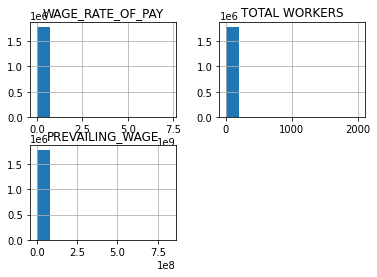

In [53]:
# Select only the numeric columns
num_df = df.select_dtypes(include=[np.number])

# Create a histogram of the numeric data
num_df.hist(bins=10)
plt.show()

##### Shapiro-Wilk test

In [54]:
# Perform Shapiro-Wilk test on each column
for col in num_df.columns:
    stat, p = shapiro(num_df[col])
    print(f"{col}: stat={stat:.3f}, p={p:.3f}")

WAGE_RATE_OF_PAY: stat=0.000, p=0.000
TOTAL WORKERS: stat=0.181, p=0.000
PREVAILING_WAGE: stat=0.002, p=0.000


Based on the results of the Shapiro-Wilk test and histograms, it appears that none of the variables are normally distributed. This is because the p-value for each variable is less than 0.05, which is a common threshold for rejecting the null hypothesis that the data is normally distributed.

##### Correlation

In [55]:
correlation_matrix = df.corr()
correlation_matrix

,WAGE_RATE_OF_PAY,TOTAL WORKERS,PREVAILING_WAGE
WAGE_RATE_OF_PAY,1.000000,-0.000223,0.000268
TOTAL WORKERS,-0.000223,1.000000,0.000404
PREVAILING_WAGE,0.000268,0.000404,1.000000


<AxesSubplot:>

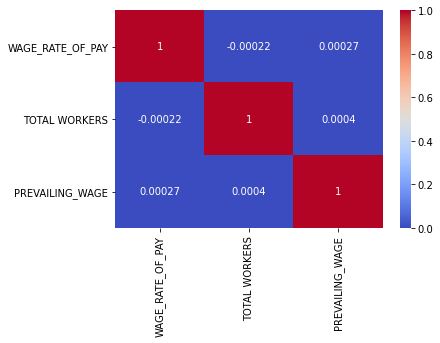

In [56]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [57]:
# Calculate Spearman's rank correlation coefficient
spearman_corr, _ = spearmanr(df['WAGE_RATE_OF_PAY'], df['PREVAILING_WAGE'])
print("Spearman's rank correlation coefficient:", spearman_corr)

# Calculate Kendall's rank correlation coefficient
kendall_corr, _ = kendalltau(df['WAGE_RATE_OF_PAY'], df['PREVAILING_WAGE'])
print("Kendall's rank correlation coefficient:", kendall_corr)

Spearman's rank correlation coefficient: 0.9014366393267162
Kendall's rank correlation coefficient: 0.7729321541063994


'WAGE_RATE_OF_PAY' column correlates with 'PREVAILING_WAGE' column, as demonstrated by the 2 tests above because it is on them that conclusions can be drawn, since the distribution of our data is not normal..

##### Box plot

A boxplot is a graphical representation of the data that shows the median, quartiles, and any outliers. Any data points that fall outside the whiskers of the boxplot can be considered outliers.

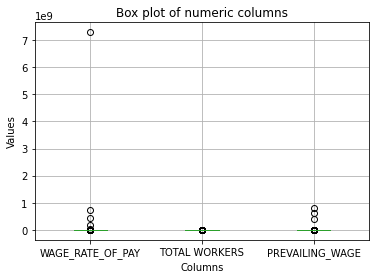

In [58]:
# Create a box plot for the numeric columns
num_df.boxplot()

plt.title("Box plot of numeric columns")
plt.xlabel("Columns")
plt.ylabel("Values")

plt.show()

##### Interquartile range (IQR)

The IQR is the range between the first quartile (25th percentile) and the third quartile (75th percentile) of the data. Data points that fall outside the range of 1.5 times the IQR below the first quartile or above the third quartile can be considered outliers.

In [59]:
col = df['PREVAILING_WAGE']
q1 = col.quantile(0.25)
q3 = col.quantile(0.75)
iqr = q3 - q1

print('IQR for column', 'PREVAILING_WAGE', ':', iqr)

upper_fence = q3 + 1.5 * iqr
lower_fence = q1 - 1.5 * iqr

# Identify and remove outliers
df = df[(df['PREVAILING_WAGE'] >= lower_fence) & (df['PREVAILING_WAGE'] <= upper_fence)]

IQR for column PREVAILING_WAGE : 27756.0


Tha same method will be used for "WAGE_RATE_OF_PAY"

In [60]:
col = df['WAGE_RATE_OF_PAY']
q1 = col.quantile(0.25)
q3 = col.quantile(0.75)
iqr = q3 - q1

print('IQR for column', 'WAGE_RATE_OF_PAY', ':', iqr)

upper_fence = q3 + 1.5 * iqr
lower_fence = q1 - 1.5 * iqr

# Identify and remove outliers
df = df[(df['WAGE_RATE_OF_PAY'] >= lower_fence) & (df['WAGE_RATE_OF_PAY'] <= upper_fence)]

IQR for column WAGE_RATE_OF_PAY : 28411.0


In [61]:
(df['TOTAL WORKERS']>300).sum() 

1

To drop the rows in a DataFrame where values of 'TOTAL WORKERS' column is higher than 300

In [62]:
# Drop the rows where TOTAL WORKERS > 300
df = df.drop(index=df[df['TOTAL WORKERS'] > 300].index)

## Feature Engineering

### Merged dataset

In [63]:
# Convert "CASE_SUBMITTED" column to datetime format
df["CASE_SUBMITTED"] = pd.to_datetime(df["CASE_SUBMITTED"])

# Create a new column "YEAR" that contains the year of the petition
df["YEAR"] = df["CASE_SUBMITTED"].dt.year

# Create a new column "MONTH" that contains the month of the petition
df["MONTH"] = df["CASE_SUBMITTED"].dt.month

To convert the 'WAGE_RATE_OF_PAY' and 'PREVAILING_WAGE' columns to the same unit as the 'WAGE_UNIT_OF_PAY' column

In [64]:
conversion_factors = {
    'Hour': 160,  # assuming 40-hour work weeks and 4 weeks per month
    'Week': 4,
    'Bi-Weekly': 2,
    'Month': 1,
    'Year': 1/12
}

# Determine the unit of the WAGE_UNIT_OF_PAY column
unit = df['WAGE_UNIT_OF_PAY'].unique()[0]

# Determine the conversion factor to convert the WAGE_UNIT_OF_PAY to 'month'
conversion_factor = conversion_factors[unit]

# Convert the WAGE_RATE_OF_PAY and PREVAILING_WAGE columns to 'month' unit
df['WAGE_RATE_OF_PAY_MONTHLY'] = df['WAGE_RATE_OF_PAY'].apply(lambda x: x*conversion_factor if x else x)
df['PREVAILING_WAGE_MONTHLY'] = df['PREVAILING_WAGE'].apply(lambda x: x*conversion_factor if x else x)

Firstly, we need to determine the conversion factor by creating a dictionary of conversion factors for each unit to the desired unit - 'month'. Then use the apply() method with a lambda function to convert the values in the 'WAGE_RATE_OF_PAY' and 'PREVAILING_WAGE' columns to the desired unit.

<AxesSubplot:>

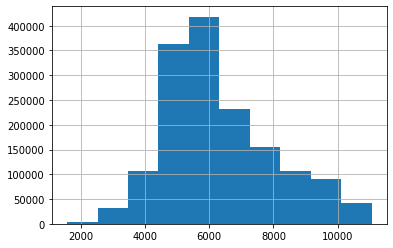

In [65]:
# Histogram of 'WAGE_RATE_OF_PAY_MONTHLY'
df['WAGE_RATE_OF_PAY_MONTHLY'].hist()

<AxesSubplot:>

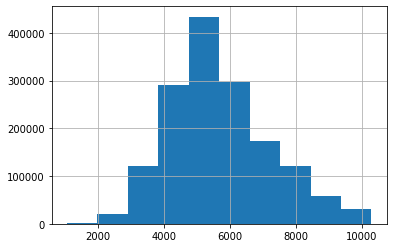

In [66]:
# Histogram of 'PREVAILING_WAGE_MONTHLY'
df['PREVAILING_WAGE_MONTHLY'].hist()

In [67]:
# Extract only the date part
df['CASE_SUBMITTED'] = df['CASE_SUBMITTED'].dt.date
df['DECISION_DATE'] = df['DECISION_DATE'].dt.date

Duration of waiting results (in days)

In [68]:
df['DURATION']=df['DECISION_DATE']-df['CASE_SUBMITTED']
df['DURATION'] = df['DURATION'].dt.days

Period of Employment (in years)

In [69]:
df['PERIOD_OF_EMPLOYMENT']=df['EMPLOYMENT_END_DATE']-df['EMPLOYMENT_START_DATE']
df['PERIOD_OF_EMPLOYMENT'] = df['PERIOD_OF_EMPLOYMENT'].dt.days
df['PERIOD_OF_EMPLOYMENT']=df['PERIOD_OF_EMPLOYMENT']/365

Encode the "CASE_STATUS" column as a binary variable indicating whether the petition was successful or not.

In [70]:
df['SUCCESSFUL_PETITION'] = (df['CASE_STATUS'] == 'CERTIFIED') * 1

This will create a new column "Successful Petition" that has a value of 1 if the petition was successful and 0 otherwise

### Additional dataset

Source: The Bureau of Labor Statistics (BLS) is the primary source of labor market data in the United States. They provide monthly unemployment rate data by state, as well as a wide range of other labor market statistics

In [71]:
add_df=pd.read_csv('./data/new_data.csv')
add_df

,WORKSITE_STATE,YEAR,NUMBER_OF_EMPLOYERS_MLN,UNEMPLOYMENT_RATE,AVG_MONTHLY_SALARY
0,AL,2014,1.900,6.8,3572.0
1,AL,2015,2.000,6.1,3672.0
2,AL,2016,2.000,5.9,3763.0
3,AK,2014,0.300,6.9,6071.0
4,AK,2015,0.300,6.5,6262.0
...,...,...,...,...,...
142,WV,2015,0.751,6.8,3338.0
143,WV,2016,0.731,5.9,3373.0
144,WI,2014,2.898,5.5,3938.0
145,WI,2015,2.937,4.6,4007.0


NUMBER_OF_EMPLOYERS_MLN: Number of employed people at the end of the year (in millions)

UNEMPLOYMENT_RATE: Unemployment rate in different states by year

AVG_MONTHLY_SALARY: Average salary by state

In [72]:
# Merge the two datasets based on WORKSITE_STATE and YEAR columns
df = pd.merge(df, add_df, on=['WORKSITE_STATE', 'YEAR'], how='left')
df

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,SOC_CODE,...,YEAR,MONTH,WAGE_RATE_OF_PAY_MONTHLY,PREVAILING_WAGE_MONTHLY,DURATION,PERIOD_OF_EMPLOYMENT,SUCCESSFUL_PETITION,NUMBER_OF_EMPLOYERS_MLN,UNEMPLOYMENT_RATE,AVG_MONTHLY_SALARY
0,I-200-09106-546545,CERTIFIED-WITHDRAWN,2013-01-18,2014-09-29,2013-02-01,2016-02-01,TEXAS STATE UNIVERSITY-SAN MARCOS,SAN MARCOS,TX,19-1029,...,2013,1,4166.666667,3593.166667,619,3.000000,0,NaN,NaN,NaN
1,I-200-09162-143337,CERTIFIED,2014-03-17,2014-03-21,2014-09-15,2017-09-15,"EYE SPECIALISTS OF INDIANA, P.C.",INDIANAPOLIS,IN,29-1041,...,2014,3,5416.666667,5354.250000,4,3.002740,1,2.920,5.8,3625.0
2,I-200-09182-550211,DENIED,2014-03-14,2014-03-20,2014-04-01,2015-04-01,"LHB, INC.",DULUTH,MN,27-2011,...,2014,3,4166.666667,4166.666667,6,1.000000,0,2.898,5.5,3938.0
3,I-200-09193-873099,CERTIFIED,2014-03-01,2014-03-06,2014-08-28,2017-08-27,"WAM USA, INC.",LAWRENCEVILLE,GA,13-2011,...,2014,3,4000.000000,3952.000000,5,3.000000,1,4.400,7.2,4050.0
4,I-200-09197-120609,CERTIFIED-WITHDRAWN,2014-03-10,2014-03-17,2014-09-01,2017-09-01,"DFUSE TECHNOLOGIES, INC.",ASHBURN,VA,15-1131,...,2014,3,5166.666667,5132.416667,7,3.002740,0,16.100,7.5,5669.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549213,I-200-16140-578441,CERTIFIED,2016-05-19,2016-05-25,2016-06-01,2017-05-31,UNIVERSITY OF MICHIGAN,ANN ARBOR,MI,17-2141,...,2016,5,4333.333333,4150.000000,6,0.997260,1,4.310,4.9,4415.0
1549214,I-200-15299-198138,CERTIFIED,2015-10-26,2015-10-30,2015-11-03,2018-11-03,HINDUJA TECH INC.,NOVI,MI,17-2141,...,2015,10,7666.666667,6272.916667,4,3.002740,1,4.280,5.4,4381.0
1549215,I-200-16071-784410,WITHDRAWN,2016-03-11,2016-03-11,2016-09-05,2019-09-04,L&T TECHNOLOGY SERVICES LIMITED,EDISON,NJ,17-2141,...,2016,3,5000.000000,4459.833333,0,2.997260,0,2.980,4.4,3682.0
1549216,I-200-15324-892450,CERTIFIED,2016-01-06,2016-01-12,2016-02-09,2019-02-06,INFOSYS LIMITED,PLANO,TX,15-1199,...,2016,1,8867.666667,8706.500000,6,2.994521,1,12.140,4.6,4462.0


In [73]:
missing_counts = df.isnull().sum()
missing_counts

CASE_NUMBER                      0
CASE_STATUS                      0
CASE_SUBMITTED                   0
DECISION_DATE                    0
EMPLOYMENT_START_DATE            0
EMPLOYMENT_END_DATE              0
EMPLOYER_NAME                    0
EMPLOYER_CITY                    0
EMPLOYER_STATE                   0
SOC_CODE                         0
SOC_NAME                         0
JOB_TITLE                        0
WAGE_RATE_OF_PAY                 0
WAGE_UNIT_OF_PAY                 0
FULL_TIME_POSITION               0
TOTAL WORKERS                    0
WORKSITE_CITY                    0
WORKSITE_STATE                   0
PREVAILING_WAGE                  0
WILLFUL_VIOLATOR                 0
YEAR                             0
MONTH                            0
WAGE_RATE_OF_PAY_MONTHLY         0
PREVAILING_WAGE_MONTHLY          0
DURATION                         0
PERIOD_OF_EMPLOYMENT             0
SUCCESSFUL_PETITION              0
NUMBER_OF_EMPLOYERS_MLN     112231
UNEMPLOYMENT_RATE   

We need this data for checking 2 hypothesis so we can drop rows with missing values

In [74]:
df_new_data = df.dropna(how='any')
df_new_data

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,SOC_CODE,...,YEAR,MONTH,WAGE_RATE_OF_PAY_MONTHLY,PREVAILING_WAGE_MONTHLY,DURATION,PERIOD_OF_EMPLOYMENT,SUCCESSFUL_PETITION,NUMBER_OF_EMPLOYERS_MLN,UNEMPLOYMENT_RATE,AVG_MONTHLY_SALARY
1,I-200-09162-143337,CERTIFIED,2014-03-17,2014-03-21,2014-09-15,2017-09-15,"EYE SPECIALISTS OF INDIANA, P.C.",INDIANAPOLIS,IN,29-1041,...,2014,3,5416.666667,5354.250000,4,3.002740,1,2.920,5.8,3625.0
2,I-200-09182-550211,DENIED,2014-03-14,2014-03-20,2014-04-01,2015-04-01,"LHB, INC.",DULUTH,MN,27-2011,...,2014,3,4166.666667,4166.666667,6,1.000000,0,2.898,5.5,3938.0
3,I-200-09193-873099,CERTIFIED,2014-03-01,2014-03-06,2014-08-28,2017-08-27,"WAM USA, INC.",LAWRENCEVILLE,GA,13-2011,...,2014,3,4000.000000,3952.000000,5,3.000000,1,4.400,7.2,4050.0
4,I-200-09197-120609,CERTIFIED-WITHDRAWN,2014-03-10,2014-03-17,2014-09-01,2017-09-01,"DFUSE TECHNOLOGIES, INC.",ASHBURN,VA,15-1131,...,2014,3,5166.666667,5132.416667,7,3.002740,0,16.100,7.5,5669.0
5,I-200-09203-855998,CERTIFIED,2014-08-20,2014-08-26,2014-08-20,2015-09-14,TAKE ENTERPRISE SERVICES INC,PRINCETON,NJ,15-1131,...,2014,8,5811.833333,4475.500000,6,1.068493,1,4.300,6.4,4238.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549213,I-200-16140-578441,CERTIFIED,2016-05-19,2016-05-25,2016-06-01,2017-05-31,UNIVERSITY OF MICHIGAN,ANN ARBOR,MI,17-2141,...,2016,5,4333.333333,4150.000000,6,0.997260,1,4.310,4.9,4415.0
1549214,I-200-15299-198138,CERTIFIED,2015-10-26,2015-10-30,2015-11-03,2018-11-03,HINDUJA TECH INC.,NOVI,MI,17-2141,...,2015,10,7666.666667,6272.916667,4,3.002740,1,4.280,5.4,4381.0
1549215,I-200-16071-784410,WITHDRAWN,2016-03-11,2016-03-11,2016-09-05,2019-09-04,L&T TECHNOLOGY SERVICES LIMITED,EDISON,NJ,17-2141,...,2016,3,5000.000000,4459.833333,0,2.997260,0,2.980,4.4,3682.0
1549216,I-200-15324-892450,CERTIFIED,2016-01-06,2016-01-12,2016-02-09,2019-02-06,INFOSYS LIMITED,PLANO,TX,15-1199,...,2016,1,8867.666667,8706.500000,6,2.994521,1,12.140,4.6,4462.0


## Exploratory Data Analysis

In [75]:
df

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,SOC_CODE,...,YEAR,MONTH,WAGE_RATE_OF_PAY_MONTHLY,PREVAILING_WAGE_MONTHLY,DURATION,PERIOD_OF_EMPLOYMENT,SUCCESSFUL_PETITION,NUMBER_OF_EMPLOYERS_MLN,UNEMPLOYMENT_RATE,AVG_MONTHLY_SALARY
0,I-200-09106-546545,CERTIFIED-WITHDRAWN,2013-01-18,2014-09-29,2013-02-01,2016-02-01,TEXAS STATE UNIVERSITY-SAN MARCOS,SAN MARCOS,TX,19-1029,...,2013,1,4166.666667,3593.166667,619,3.000000,0,NaN,NaN,NaN
1,I-200-09162-143337,CERTIFIED,2014-03-17,2014-03-21,2014-09-15,2017-09-15,"EYE SPECIALISTS OF INDIANA, P.C.",INDIANAPOLIS,IN,29-1041,...,2014,3,5416.666667,5354.250000,4,3.002740,1,2.920,5.8,3625.0
2,I-200-09182-550211,DENIED,2014-03-14,2014-03-20,2014-04-01,2015-04-01,"LHB, INC.",DULUTH,MN,27-2011,...,2014,3,4166.666667,4166.666667,6,1.000000,0,2.898,5.5,3938.0
3,I-200-09193-873099,CERTIFIED,2014-03-01,2014-03-06,2014-08-28,2017-08-27,"WAM USA, INC.",LAWRENCEVILLE,GA,13-2011,...,2014,3,4000.000000,3952.000000,5,3.000000,1,4.400,7.2,4050.0
4,I-200-09197-120609,CERTIFIED-WITHDRAWN,2014-03-10,2014-03-17,2014-09-01,2017-09-01,"DFUSE TECHNOLOGIES, INC.",ASHBURN,VA,15-1131,...,2014,3,5166.666667,5132.416667,7,3.002740,0,16.100,7.5,5669.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549213,I-200-16140-578441,CERTIFIED,2016-05-19,2016-05-25,2016-06-01,2017-05-31,UNIVERSITY OF MICHIGAN,ANN ARBOR,MI,17-2141,...,2016,5,4333.333333,4150.000000,6,0.997260,1,4.310,4.9,4415.0
1549214,I-200-15299-198138,CERTIFIED,2015-10-26,2015-10-30,2015-11-03,2018-11-03,HINDUJA TECH INC.,NOVI,MI,17-2141,...,2015,10,7666.666667,6272.916667,4,3.002740,1,4.280,5.4,4381.0
1549215,I-200-16071-784410,WITHDRAWN,2016-03-11,2016-03-11,2016-09-05,2019-09-04,L&T TECHNOLOGY SERVICES LIMITED,EDISON,NJ,17-2141,...,2016,3,5000.000000,4459.833333,0,2.997260,0,2.980,4.4,3682.0
1549216,I-200-15324-892450,CERTIFIED,2016-01-06,2016-01-12,2016-02-09,2019-02-06,INFOSYS LIMITED,PLANO,TX,15-1199,...,2016,1,8867.666667,8706.500000,6,2.994521,1,12.140,4.6,4462.0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1549218 entries, 0 to 1549217
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   CASE_NUMBER               1549218 non-null  object        
 1   CASE_STATUS               1549218 non-null  object        
 2   CASE_SUBMITTED            1549218 non-null  object        
 3   DECISION_DATE             1549218 non-null  object        
 4   EMPLOYMENT_START_DATE     1549218 non-null  datetime64[ns]
 5   EMPLOYMENT_END_DATE       1549218 non-null  datetime64[ns]
 6   EMPLOYER_NAME             1549218 non-null  object        
 7   EMPLOYER_CITY             1549218 non-null  object        
 8   EMPLOYER_STATE            1549218 non-null  object        
 9   SOC_CODE                  1549218 non-null  object        
 10  SOC_NAME                  1549218 non-null  object        
 11  JOB_TITLE                 1549218 non-null  object

### Univariate analysis

#### Continuous features

Delete 2009 because there are only 2 values that do not reap any information.

In [77]:
# Drop the rows where where 'YEAR' == 2009
df = df.drop(index=df[df['YEAR'] == 2009].index)

##### Number of petitions by YEAR

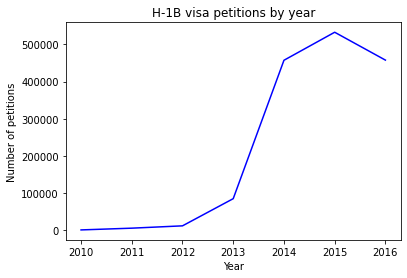

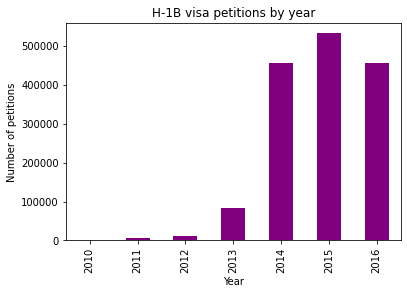

In [78]:
# Group the petitions by year and count the number of petitions
petitions_by_year = df.groupby('YEAR').count()['CASE_NUMBER']

# Plot a line chart of the number of petitions over time
petitions_by_year.plot(kind='line', x='YEAR', y='CASE_NUMBER', color='blue')
plt.xlabel('Year')
plt.ylabel('Number of petitions')
plt.title('H-1B visa petitions by year')
plt.show()

# Plot a histogram of the number of petitions over time
petitions_by_year.plot(kind='bar', x='YEAR', y='CASE_NUMBER', color='purple')
plt.xlabel('Year')
plt.ylabel('Number of petitions')
plt.title('H-1B visa petitions by year')
plt.show()

As you can see from the graph, in 2015 the most petitions were filed. 2014 and 2016 have approximately the same level in terms of the number of petitions.

##### Number of petitions by MONTH

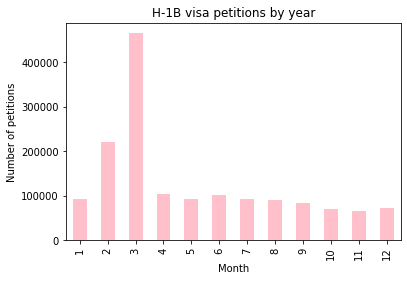

In [79]:
# Group the petitions by year and count the number of petitions
petitions_by_year = df.groupby('MONTH').count()['CASE_NUMBER']

# Plot a histogram of the number of petitions over time
petitions_by_year.plot(kind='bar', x='MONTH', y='CASE_NUMBER', color='pink')
plt.xlabel('Month')
plt.ylabel('Number of petitions')
plt.title('H-1B visa petitions by year')
plt.show()

If we look at the chart by months for 3 years, February and March stand out strongly.

There could be several reasons why the most number of H-1B visa petitions were filed in February and March:

1. Processing Time: The processing time for H-1B visa petitions can vary, but it typically takes several months. Employers who file their petitions in February or March may be more likely to receive a decision on their petitions before the start of the new fiscal year on October 1st.

2. Quota Limits: The U.S. government sets an annual cap on the number of H-1B visas that can be issued each year. Employers who file their petitions early in the year may have a better chance of securing visas for their workers before the quota is filled.

##### TOTAL WORKERS

Some graphs are limited in size on the y-axis to make it easier to see details.

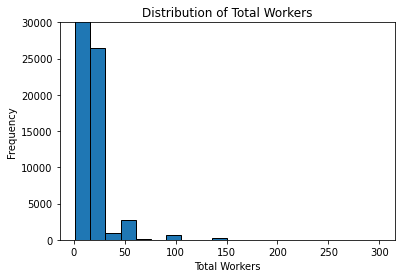

In [80]:
plt.hist(df['TOTAL WORKERS'], bins=20, edgecolor='black')

# Set the plot title and axis labels
plt.title('Distribution of Total Workers')
plt.xlabel('Total Workers')
plt.ylabel('Frequency')
plt.ylim(0, 30000)
plt.show()

In general, employers submit no more than 25-30 petitions per application.

##### WAGE_RATE_OF_PAY_MONTHLY

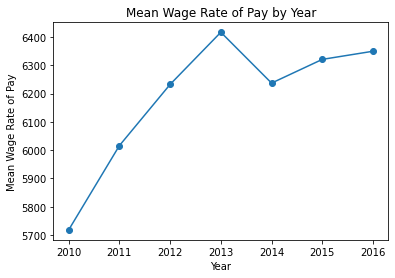

In [81]:
# Convert the CASE_SUBMITTED column to a datetime object
df['CASE_SUBMITTED'] = pd.to_datetime(df['CASE_SUBMITTED'])

# Group the data by year and compute the mean wage rate of pay for each year
grouped = df.groupby(df['YEAR'])['WAGE_RATE_OF_PAY_MONTHLY'].mean()

# Create a line plot of the mean wage rate of pay by year
plt.plot(grouped.index, grouped.values, marker='o')

# Set the plot title and axis labels
plt.title('Mean Wage Rate of Pay by Year')
plt.xlabel('Year')
plt.ylabel('Mean Wage Rate of Pay')

# Display the plot
plt.show()

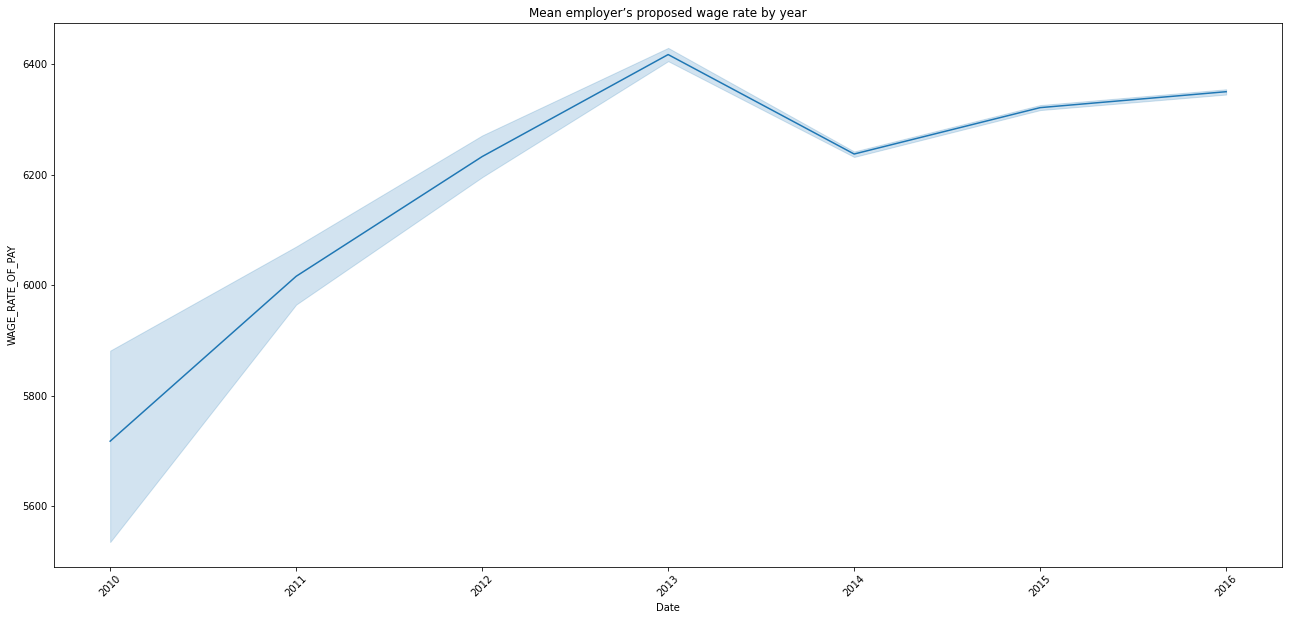

In [82]:
f, axes = plt.subplots(figsize=(22, 10))
ax = sns.lineplot(x="YEAR", y="WAGE_RATE_OF_PAY_MONTHLY", data=df, estimator='mean')
ax = ax.set(xlabel='Date', ylabel='WAGE_RATE_OF_PAY')
plt.title('Mean employer’s proposed wage rate by year')
plt.xticks(rotation=45)
plt.show()

It is difficult to unambiguously say why in 2015 there was a drawdown in the minimum rate of employers. Various factors could influence the change in the minimum wage, such as the economic situation, political pressure, public opinion, and organized labor efforts. Some states and localities may also have been affected by increases in the minimum wage in neighboring jurisdictions or changes in federal minimum wage laws.

It is also worth noting that the minimum wage can vary greatly between states and localities, so changes in the minimum wage may be due to factors that are specific to each jurisdiction.

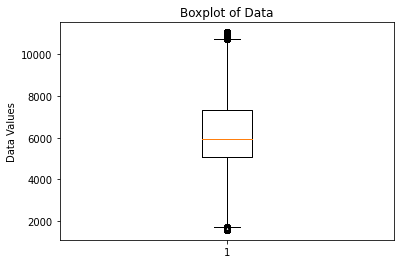

In [83]:
# Box plot
plt.boxplot(df['WAGE_RATE_OF_PAY_MONTHLY'])
plt.title('Boxplot of Data')
plt.ylabel('Data Values')
plt.show()


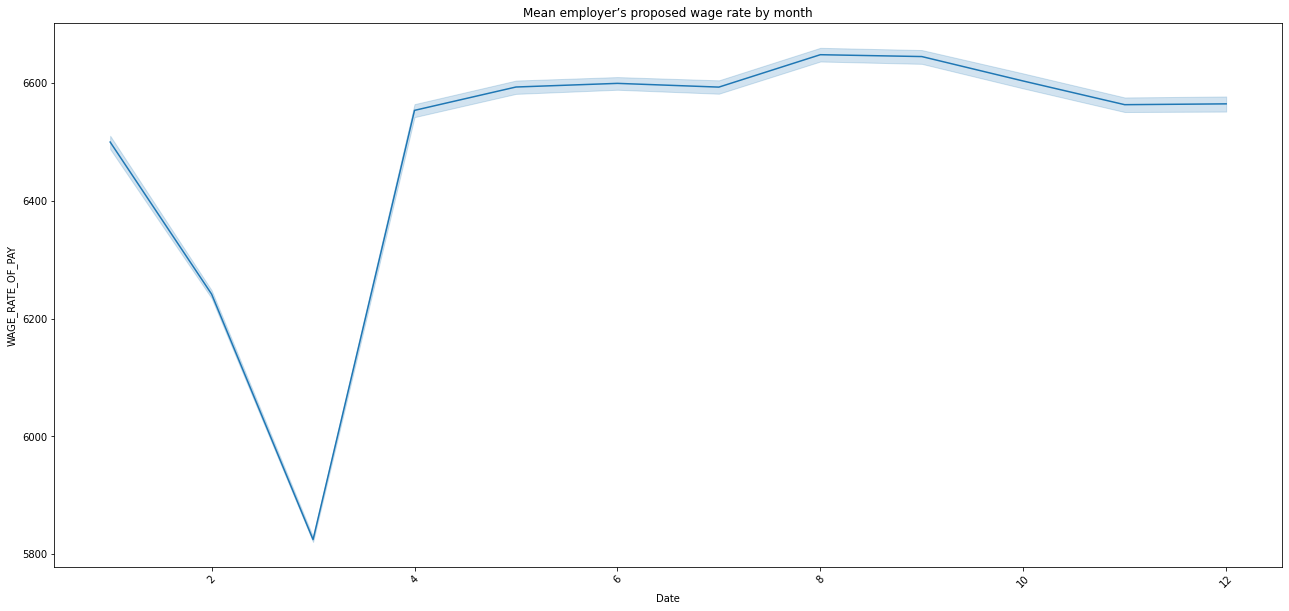

In [84]:
f, axes = plt.subplots(figsize=(22, 10))
ax = sns.lineplot(x="MONTH", y="WAGE_RATE_OF_PAY_MONTHLY", data=df, estimator='mean')
ax = ax.set(xlabel='Date', ylabel='WAGE_RATE_OF_PAY')
plt.title('Mean employer’s proposed wage rate by month')
plt.xticks(rotation=45)
plt.show()

The graph above showed that in March, the largest number of petitions is sent by employers. It can be assumed that the law of supply and demand operates here, and the more applicants, the more intensively employers reduce their minimum rate.

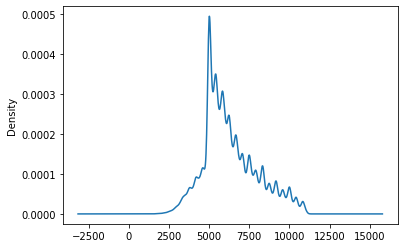

In [85]:
# Create a density plot of the wage column
df['WAGE_RATE_OF_PAY_MONTHLY'].plot(kind='density')
plt.show()

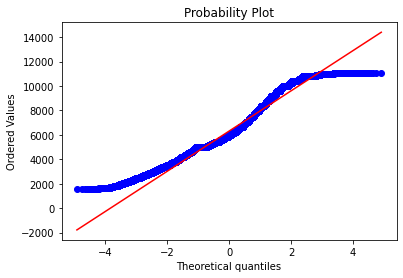

In [86]:
# Create a probability plot of the wage column
stats.probplot(df['WAGE_RATE_OF_PAY_MONTHLY'], dist="norm", plot=plt)
plt.show()

##### PREVAILING_WAGE_MONTHLY

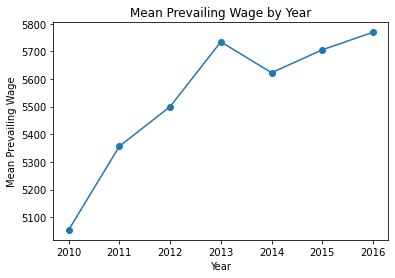

In [87]:
# Convert the CASE_SUBMITTED column to a datetime object
df['CASE_SUBMITTED'] = pd.to_datetime(df['CASE_SUBMITTED'])

# Group the data by year and compute the mean wage rate of pay for each year
grouped = df.groupby(df['YEAR'])['PREVAILING_WAGE_MONTHLY'].mean()

# Create a line plot of the mean wage rate of pay by year
plt.plot(grouped.index, grouped.values, marker='o')

# Set the plot title and axis labels
plt.title('Mean Prevailing Wage by Year')
plt.xlabel('Year')
plt.ylabel('Mean Prevailing Wage')

# Display the plot
plt.show()

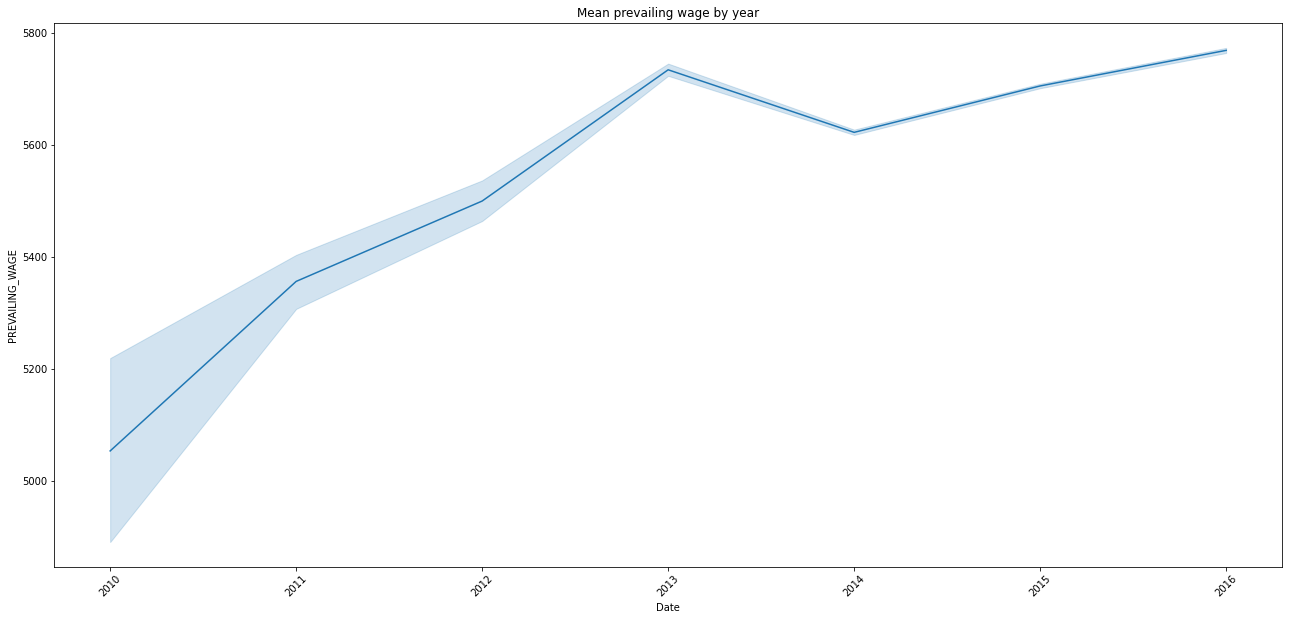

In [88]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.lineplot(x="YEAR", y="PREVAILING_WAGE_MONTHLY", data=df, estimator='mean')
ax = ax.set(xlabel='Date', ylabel='PREVAILING_WAGE')
plt.title('Mean prevailing wage by year')
plt.xticks(rotation=45)
plt.show()

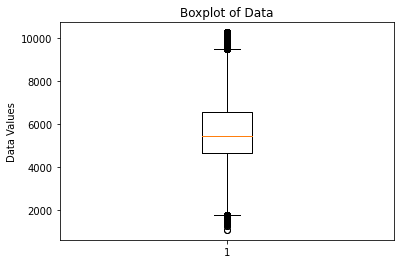

In [89]:
# Box plot
plt.boxplot(df['PREVAILING_WAGE_MONTHLY'])
plt.title('Boxplot of Data')
plt.ylabel('Data Values')
plt.show()

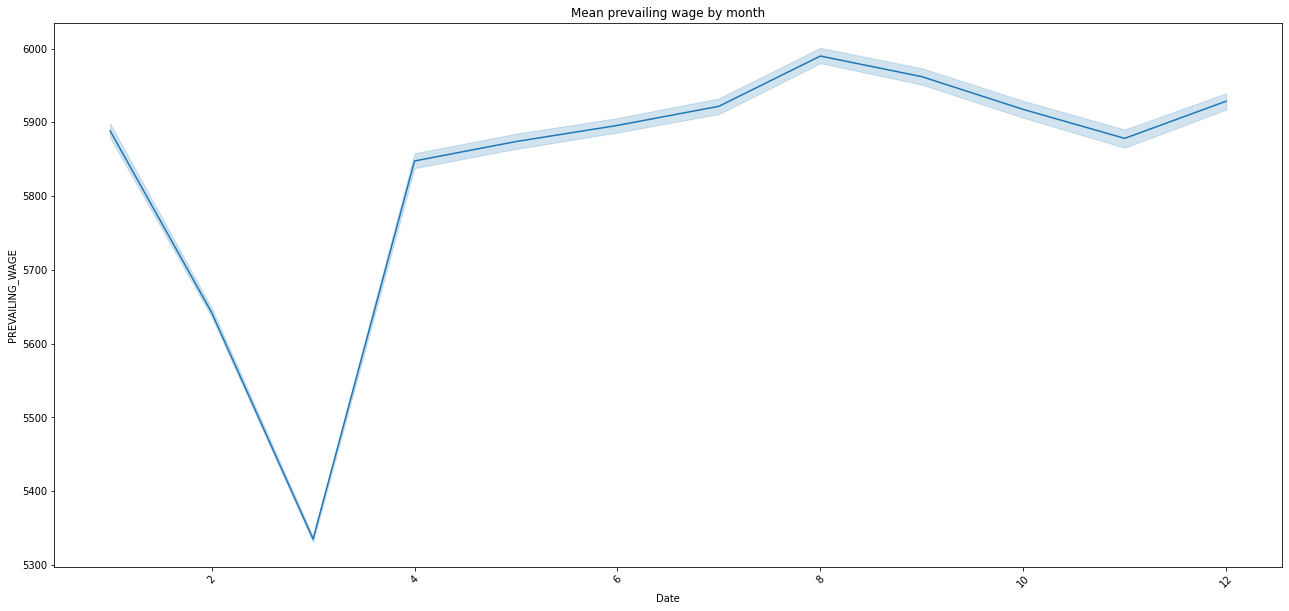

In [90]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.lineplot(x="MONTH", y="PREVAILING_WAGE_MONTHLY", data=df, estimator='mean')
ax = ax.set(xlabel='Date', ylabel='PREVAILING_WAGE')
plt.title('Mean prevailing wage by month')
plt.xticks(rotation=45)
plt.show()

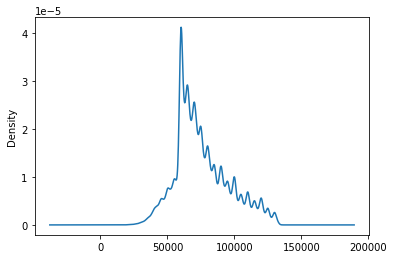

In [91]:
# Create a density plot of the wage column
df['WAGE_RATE_OF_PAY'].plot(kind='density')
plt.show()

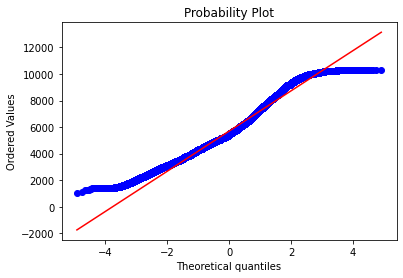

In [92]:
stats.probplot(df['PREVAILING_WAGE_MONTHLY'], dist="norm", plot=plt)
plt.show()

The same trends are observed here, which is not surprising, since these two variables are highly correlated.

There are several reasons why the minimum wage rate for H-1B visa holders would correlate with the prevailing wage:

Employers are required by law to pay H-1B visa holders at least the prevailing wage for their occupation and geographic area. If the employer pays less than the prevailing wage, they risk being found in violation of the law and facing penalties or losing their ability to sponsor H-1B visas in the future. Therefore, employers have an incentive to pay at least the prevailing wage.

H-1B visa holders may be willing to accept lower wages than U.S. workers because they may be seeking work experience or other opportunities that will help them secure future employment or permanent residency in the United States. This could create a situation where employers may pay the minimum required wage, rather than the actual prevailing wage for the position.

The prevailing wage is based on data collected by the DOL, which takes into account the wages paid by other employers in the same geographic area and for the same occupation. Therefore, the prevailing wage is a good benchmark for what an H-1B visa holder should be paid for that particular job. Employers who pay the minimum required wage are likely paying close to the prevailing wage anyway, which would result in a correlation between the two variables.

In summary, the correlation between the minimum wage rate for H-1B visa holders and the prevailing wage for that occupation and geographic area is likely due to legal requirements, the willingness of H-1B visa holders to accept lower wages, and the use of the prevailing wage as a benchmark for setting wages.

##### DURATION

Some graphs are limited in size on the y-axis to make it easier to see details.

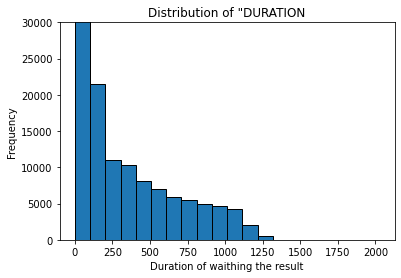

In [93]:
plt.hist(df['DURATION'], bins=20, edgecolor='black')

# Set the plot title and axis labels
plt.title('Distribution of "DURATION')
plt.xlabel('Duration of waithing the result')
plt.ylabel('Frequency')
plt.ylim(0, 30000)
plt.show()

In [94]:
(df['DURATION']>7).sum()

184345

Only 10% of all petitions over 3 years are considered for longer than 1 week.

##### PERIOD_OF_EMPLOYMENT

In [95]:
(df['PERIOD_OF_EMPLOYMENT']<0).sum()

10

Drop rows where 'PERIOD_OF_EMPLOYMENT' less than 0 because it's impossible

In [96]:
# Drop the rows where 'PERIOD_OF_EMPLOYMENT'<0
df = df.drop(index=df[df['PERIOD_OF_EMPLOYMENT']<0].index)

Some graphs are limited in size on the y-axis to make it easier to see details.

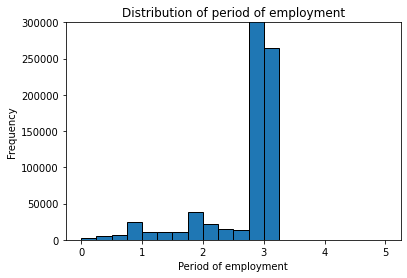

In [97]:
plt.hist(df['PERIOD_OF_EMPLOYMENT'], bins=20, edgecolor='black')

# Set the plot title and axis labels
plt.title('Distribution of period of employment')
plt.xlabel('Period of employment')
plt.ylabel('Frequency')
plt.ylim(0, 300000)
plt.show()

The main share of petitions falls on long-term contracts of 3 years

##### Discrete features

##### EMPLOYER_NAME

Number of unique employers:

In [98]:
# count the number of unique values in a column
unique_values_count = len(df['EMPLOYER_NAME'].unique())
unique_values_count

112681

##### SUCCESSFUL_PETITION

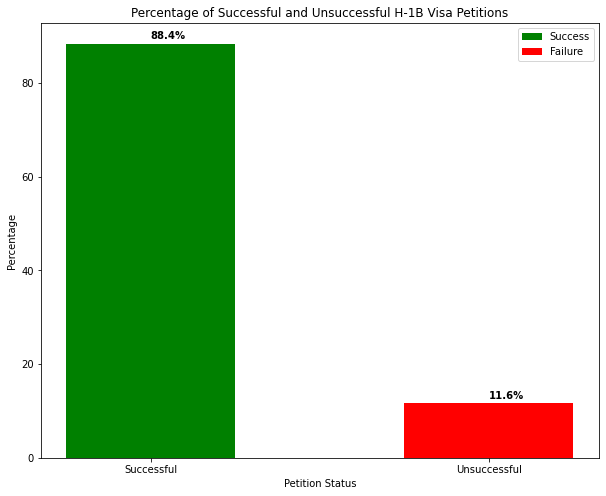

In [101]:
# Count the number of petitions by case status
counts = df['SUCCESSFUL_PETITION'].value_counts()

# Calculate the percentage of successful and unsuccessful petitions
success_pct = 100 * (counts[1] / counts.sum())
failure_pct = 100 - success_pct

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Create the bar chart
bars = ax.bar([0, 1], [success_pct, failure_pct], color=['green', 'red'], width=0.5)

# Set the chart title and axis labels
plt.title('Percentage of Successful and Unsuccessful H-1B Visa Petitions')
plt.xlabel('Petition Status')
plt.ylabel('Percentage')

# Set the x-tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['Successful', 'Unsuccessful'])

# Add the percentage values to the bars
for i, v in enumerate([success_pct, failure_pct]):
    ax.text(i, v + 1, f'{v:.1f}%', fontweight='bold')
    
# Add legends to the bars
ax.legend(bars, ['Success', 'Failure'])


# Display the chart
plt.show()

88.4% is the share of successful applications, 11.6% rejected, denied, withdrawn and certified-withdrawn

##### EMPLOYER_STATE

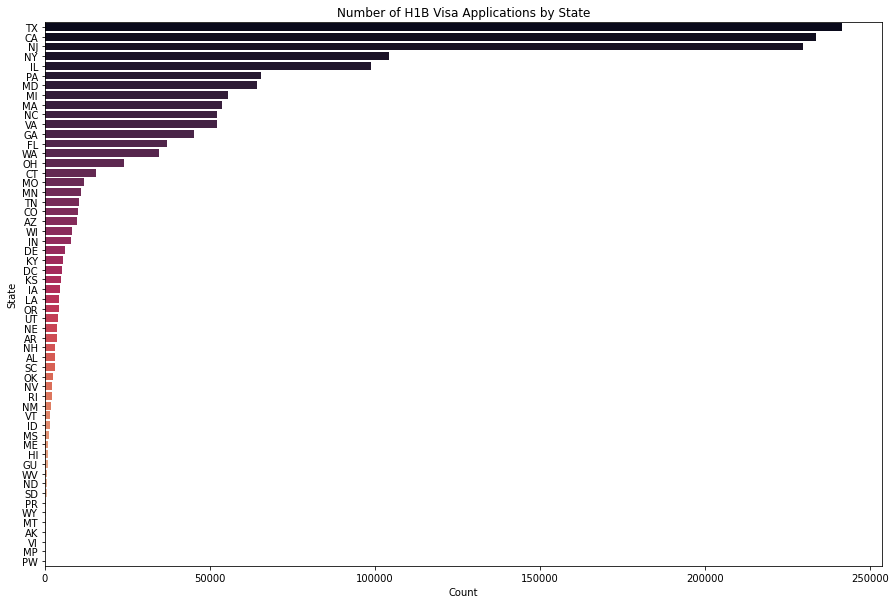

In [102]:
# Create a countplot using seaborn
plt.figure(figsize=(15,10))
sns.countplot(y='EMPLOYER_STATE', data=df, order=df['EMPLOYER_STATE'].value_counts().index, palette='rocket')

plt.title('Number of H1B Visa Applications by State')
plt.xlabel('Count')
plt.ylabel('State')
plt.show()

Top 3 states by number of H-1B visa petitions: Texas, California, New Jersey

##### WAGE_UNIT_OF_PAY

In [103]:
# Count the number of full-time and part-time positions
counts = df['WAGE_UNIT_OF_PAY'].value_counts()
counts

Year         1548688
Hour             342
Month            154
Bi-Weekly         12
Week              11
Name: WAGE_UNIT_OF_PAY, dtype: int64

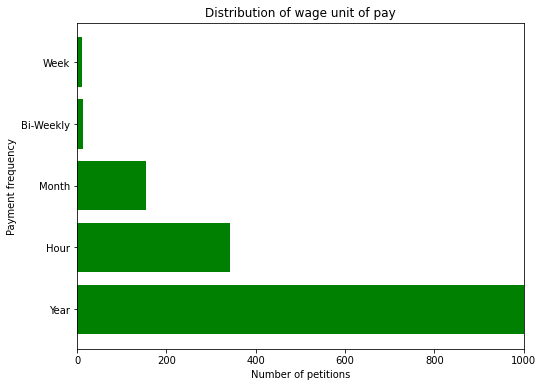

In [104]:
# Create the bar chart
plt.figure(figsize=(8,6))
plt.barh(counts.index, counts.values, color='green')
plt.title('Distribution of wage unit of pay')
plt.xlabel('Number of petitions')
plt.ylabel('Payment frequency')
plt.xlim(0, 1000)
plt.show()

Here the annual payment prevails. And then hourly.

##### FULL_TIME_POSITION

In [105]:
# Count the number of full-time and part-time positions
counts = df['FULL_TIME_POSITION'].value_counts()
counts

Y    1549185
N         22
Name: FULL_TIME_POSITION, dtype: int64

Looking at the numbers, part time is more of an exception than a pattern.

##### WILLFUL_VIOLATOR 

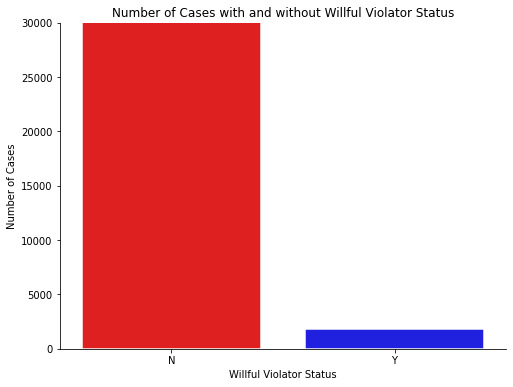

In [106]:
# Count the number of cases with and without willful violator status
counts = df['WILLFUL_VIOLATOR'].value_counts()

# Plot the bar chart 
plt.figure(figsize=(8,6))
sns.barplot(x=counts.index, y=counts.values, palette=['red', 'blue'], edgecolor='white', linewidth=1.5)
sns.despine()
plt.title('Number of Cases with and without Willful Violator Status')
plt.xlabel('Willful Violator Status')
plt.ylabel('Number of Cases')
plt.ylim(0, 30000)
plt.show()


In [107]:
(df['WILLFUL_VIOLATOR']=='Y').sum()

1785

0,1% of employers who has been previously found to be a Willful Violator

### Multivariate analysis

##### Q1. Which employers file the most petitions each year? 

To determine which employers filed the most petitions each year for H-1B, H-1B1, and E-3 visas:

In [108]:
petitions_by_employer = df.groupby(['YEAR', 'EMPLOYER_NAME'])['EMPLOYER_NAME'].count()

In [109]:
top_employers = petitions_by_employer.groupby('YEAR').idxmax()

In [110]:
for year, employer in top_employers.iteritems():
    print(f"In {year}, the employer who filed the most petitions was {employer[1]} with {petitions_by_employer.loc[(year, employer[1])]} petitions.")

In 2010, the employer who filed the most petitions was AKKEN INC with 12 petitions.
In 2011, the employer who filed the most petitions was MICROSOFT CORPORATION with 113 petitions.
In 2012, the employer who filed the most petitions was MICROSOFT CORPORATION with 339 petitions.
In 2013, the employer who filed the most petitions was INFOSYS LIMITED with 3017 petitions.
In 2014, the employer who filed the most petitions was INFOSYS LIMITED with 24865 petitions.
In 2015, the employer who filed the most petitions was INFOSYS LIMITED with 30918 petitions.
In 2016, the employer who filed the most petitions was INFOSYS LIMITED with 21873 petitions.


It shows that the number of petitions filed by Infosys Limited has been increasing over the years and they have consistently filed the most petitions in the given years.

#####  Q2. Is the applicant wage correlated with petition success?

In [111]:
correlation = df['WAGE_RATE_OF_PAY_MONTHLY'].corr(df['SUCCESSFUL_PETITION'])
print(f"The correlation coefficient between the applicant's wage and petition success is {correlation:.2f}.")

The correlation coefficient between the applicant's wage and petition success is 0.02.


A correlation coefficient of 0.02 suggests that there is a very weak positive correlation between the applicant's wage and petition success. This means that there is a slight tendency for higher wage applicants to have a slightly higher success rate in their visa applications, but the relationship is not strong enough to draw any meaningful conclusions. It is also important to keep in mind that correlation does not imply causation, so even if there was a strong correlation between the applicant's wage and petition success, it would not necessarily mean that a higher wage causes a higher success rate in visa applications. 

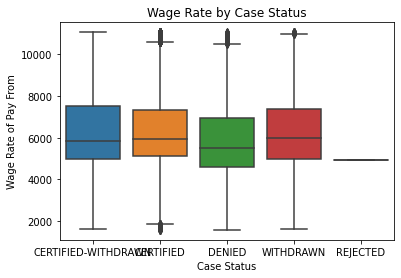

In [112]:
# Create a box plot of wage rate by case status
sns.boxplot(x='CASE_STATUS', y='WAGE_RATE_OF_PAY_MONTHLY', data=df)

# Set the plot title and axis labels
plt.title('Wage Rate by Case Status')
plt.xlabel('Case Status')
plt.ylabel('Wage Rate of Pay From')

# Display the plot
plt.show()

The box plot shows the distribution of the wage rate for successful and unsuccessful H-1B visa petitions. 

In general, the size of the minimum wage rate does not correlate with success of a petion, but I decided to see if there are cases when the proposed salary from employers is lower than the prevailing wage.

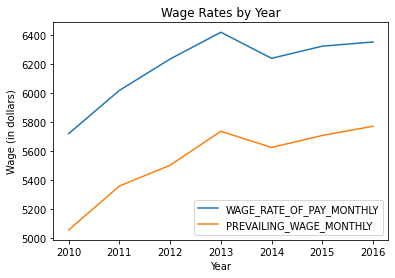

In [113]:
# group the data by year and calculate the mean of WAGE_RATE_OF_PAY and PREVAILING_WAGE
df_yearly = df.groupby(df['YEAR'])[['WAGE_RATE_OF_PAY_MONTHLY', 'PREVAILING_WAGE_MONTHLY']].mean()

# create a line graph of the two variables over time
df_yearly.plot(kind='line')

# add labels and a title to the plot
plt.xlabel('Year')
plt.ylabel('Wage (in dollars)')
plt.title('Wage Rates by Year')

# display the plot
plt.show()

On average a wage rate of employers is always higher than a prevailing wage

Now create a dataframe from the opposite case, when a wage rate of employers is less than a prevailing wage. And let's see the percentage of failures for employers offering wages lower than prevailing wage from the Department of Labor

In [114]:
filtered_df = df[df['WAGE_RATE_OF_PAY_MONTHLY'] < df['PREVAILING_WAGE_MONTHLY']]

# Calculate the total number of rows in the filtered_df dataset
total_rows = len(filtered_df)

# Calculate the number of rows where 'WAGE_RATE_OF_PAY_MONTHLY' is less than or equal to 'PREVAILING_WAGE_MONTHLY'
failure_rows = len(filtered_df[filtered_df['CASE_STATUS'] == 'DENIED'])

# Calculate the percentage of failures
failure_percentage = (failure_rows / total_rows) * 100

# Print the percentage of failures
print(f"The percentage of failures is {failure_percentage:.2f}%")


The percentage of failures is 82.57%


A rather high percentage, by which it can be concluded that the wage does not affect the success of the petitions because the correlation is weak, but if the employer's wage does not reach the threshold value, i.e. prevailing wage, then the probability of failure is high.

##### Q3. Which SOC names are more popular among employers and employees?

In [115]:
# Group by year and SOC_NAME and count the number of petitions for each group
grouped = df.groupby(['YEAR', 'SOC_NAME'])['SOC_NAME'].count()

# Find the SOC_NAME with the highest count for each year
top_SOC = grouped.groupby('YEAR').idxmax().reset_index()
top_SOC

,YEAR,SOC_NAME
0,2010,"(2010, Computer Systems Analysts)"
1,2011,"(2011, Computer Systems Analysts)"
2,2012,"(2012, Software Developers, Applications)"
3,2013,"(2013, Computer Systems Analysts)"
4,2014,"(2014, Computer Systems Analysts)"
5,2015,"(2015, COMPUTER SYSTEMS ANALYSTS)"
6,2016,"(2016, SOFTWARE DEVELOPERS, APPLICATIONS)"


The most popular direction throughout the period was the computer systems analyst

Let's look at the same picture but by state. Does it depend on states?

In [116]:
# Group by year and SOC_NAME and count the number of petitions for each group
grouped = df.groupby(['WORKSITE_STATE', 'SOC_NAME'])['SOC_NAME'].count()

# Find the SOC_NAME with the highest count for each year
top_SOC = grouped.groupby('WORKSITE_STATE').idxmax().reset_index()
top_SOC

,WORKSITE_STATE,SOC_NAME
0,AK,"(AK, COMPUTER OCCUPATIONS, ALL OTHER)"
1,AL,"(AL, SOFTWARE DEVELOPERS, APPLICATIONS)"
2,AR,"(AR, COMPUTER SYSTEMS ANALYSTS)"
3,AZ,"(AZ, COMPUTER SYSTEMS ANALYSTS)"
4,CA,"(CA, SOFTWARE DEVELOPERS, APPLICATIONS)"
5,CO,"(CO, SOFTWARE DEVELOPERS, APPLICATIONS)"
6,CT,"(CT, COMPUTER SYSTEMS ANALYSTS)"
7,DC,"(DC, COMPUTER PROGRAMMERS)"
8,DE,"(DE, COMPUTER SYSTEMS ANALYSTS)"
9,FL,"(FL, COMPUTER SYSTEMS ANALYSTS)"


In the context of the states, we also see that computer science prevails, but 3 states are an exception, where the sphere of finance, education and art is more popular

What about job titles?

In [117]:
# Group the data by JOB_TITLE and count the number of petitions
jobtitle_counts = df.groupby("JOB_TITLE")["CASE_NUMBER"].count()

# Sort the JOB_TITLEs by the number of petitions
jobtitle_counts = jobtitle_counts.sort_values(ascending=False)

jobtitle_counts.head(10)

JOB_TITLE
PROGRAMMER ANALYST          144911
SOFTWARE ENGINEER            68782
COMPUTER PROGRAMMER          38908
SYSTEMS ANALYST              33656
SOFTWARE DEVELOPER           29955
BUSINESS ANALYST             22701
COMPUTER SYSTEMS ANALYST     20446
TECHNOLOGY LEAD - US         18479
TECHNOLOGY ANALYST - US      16725
CONSULTANT                   13844
Name: CASE_NUMBER, dtype: int64

Top 10 only about programmers, analysts. engineer - anything related to IT. It's true, IT was so popular that period and still one of the most sought-after professional fields.

##### Q4. What categories of professions receive the most approval?

In [118]:
# Aggregate the data by SOC and calculate the approval rate for each SOC
soc_approval_rate = df.groupby("SOC_NAME")["CASE_STATUS"].apply(lambda x: (x == "CERTIFIED").sum() / len(x)).reset_index(name="APPROVAL_RATE")
soc_approval_rate = soc_approval_rate.sort_values(by='APPROVAL_RATE', ascending=False)

soc_approval_rate.head(25)

,SOC_NAME,APPROVAL_RATE
0,13-2011.01,1.0
504,"DRILLING AND BORING MACHINE TOOL SETTERS,",1.0
488,DENTISTS,1.0
1220,"PHYSICIANS AND SURGEONS, ALL OTHERS",1.0
493,"DESIGNERS, ALL OTHERS",1.0
1217,"PHYSICIANS &AMP; SURGEONS, ALL OTHER",1.0
1216,"PHYSICIANS & SURGEONS, ALL OTHER",1.0
500,"DIRECTORS- STAGE, MOTION PICTURES, TELEVISION,...",1.0
501,"DISPATCHERS, EXCEPT POLICE, FIRE, AND AMBULANCE",1.0
1211,PHYSICAL THERAPIST,1.0


As we can see, one of the lines has lost its name and has only a code, but we can easily recognize which category it belongs to.

In [119]:
filtered_df = df.loc[df['SOC_CODE'] == '13-2011.01', 'SOC_NAME']
filtered_df

190        Accountants
274        Accountants
747        Accountants
1175       Accountants
1698       Accountants
              ...     
1035765    ACCOUNTANTS
1035766    ACCOUNTANTS
1035767    ACCOUNTANTS
1035768    ACCOUNTANTS
1035769    ACCOUNTANTS
Name: SOC_NAME, Length: 181, dtype: object

The pool of 100% approvals for the most part includes professions from public services.

##### Q5. Is a Willful Violator a flag for later deny?

In [120]:
# Group by WILLFUL_VIOLATOR and calculate approval rate
approval_rate_by_willful_violator = df.groupby('WILLFUL_VIOLATOR')['CASE_STATUS'].value_counts(normalize=True).loc[:, 'CERTIFIED']

In [121]:
approval_rate_by_willful_violator

WILLFUL_VIOLATOR
N    0.883672
Y    0.807843
Name: CASE_STATUS, dtype: float64

This code will group the dataset by the values in the "WILLFUL_VIOLATOR" column and calculate the approval rate for each group.

The percentage of approvals of employers not recognized as Willful Violators was, as expected, higher than the percentage recognized, but not very high. It can be concluded that this parameter does not greatly affect the success of consideration of petitions.


##### Q6. What is the failure rate by state? 

This code will produce a bar chart showing the failure rate (i.e., the percentage of denied petitions) for each state, sorted in descending order. States with higher failure rates will appear towards the top of the chart.

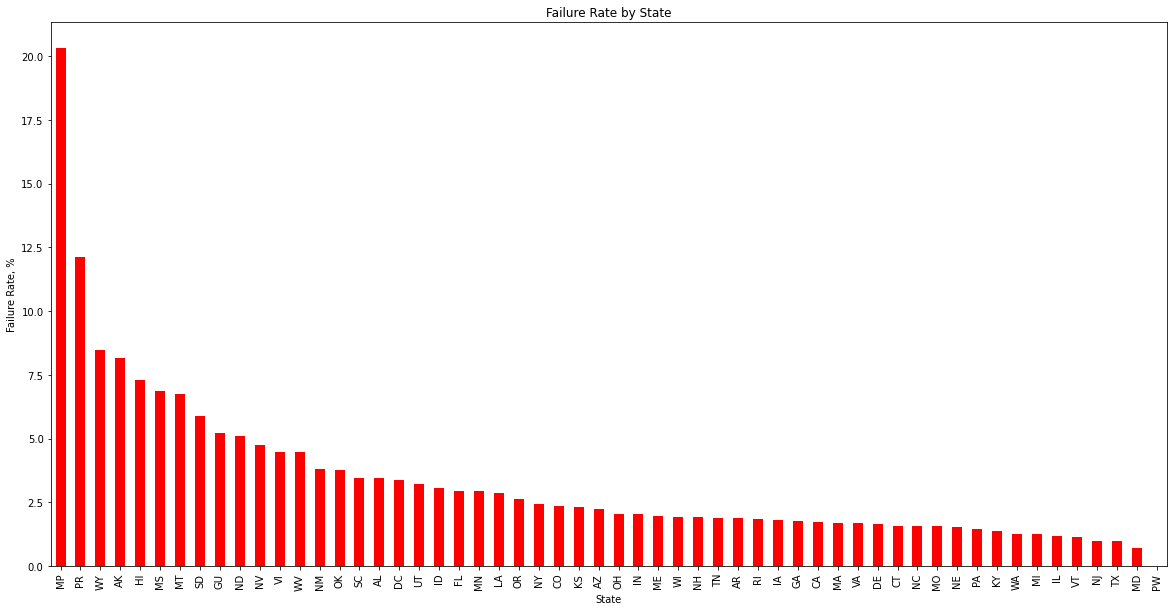

In [122]:
# Calculate the total number of petitions filed and denied for each state
state_counts = df.groupby(["EMPLOYER_STATE", "CASE_STATUS"]).size().unstack().fillna(0)
state_counts["total"] = state_counts.sum(axis=1)
state_counts["failure"] = (state_counts["DENIED"] / state_counts["total"])*100

# Sort the data by failure rate
state_counts = state_counts.sort_values(by="failure", ascending=False)

# Create a bar chart of the failure rate by state
state_counts["failure"].plot(kind="bar", figsize=(20, 10), color="red")
plt.title("Failure Rate by State")
plt.xlabel("State")
plt.ylabel("Failure Rate, %")
plt.show()

In [123]:
df[df['EMPLOYER_STATE']=='PW']

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,SOC_CODE,...,YEAR,MONTH,WAGE_RATE_OF_PAY_MONTHLY,PREVAILING_WAGE_MONTHLY,DURATION,PERIOD_OF_EMPLOYMENT,SUCCESSFUL_PETITION,NUMBER_OF_EMPLOYERS_MLN,UNEMPLOYMENT_RATE,AVG_MONTHLY_SALARY
1198908,I-200-16069-297151,CERTIFIED,2016-03-10,2016-03-16,2016-09-08,2019-09-07,"SIRI GROUP, INC.",KING OF PRUSSIA,PW,15-1131,...,2016,3,4333.333333,4310.833333,6,2.99726,1,4.4,5.0,5805.0
1512379,I-200-16202-645185,CERTIFIED,2016-07-27,2016-08-02,2016-08-26,2019-08-25,"TYCO ELECTRONICS CORPORATION, A TE CONNECTIVIT...",BERWYN,PW,19-2032,...,2016,7,10147.166667,9080.916667,6,2.99726,1,17.4,5.4,6064.0


To clarify, Berwyn and King of Prussia are both located in the United States, specifically in the state of Pennsylvania (PA). 

In [124]:
# Update the values in col 'EMPLOYER_STATE' where the value is 'PW' to 'PA'
df.loc[df['EMPLOYER_STATE'] == 'PW', 'EMPLOYER_STATE'] = 'PA'

The highest percentage is in the Northern Mariana Islands at about 20%, the lowest percentage is in Maryland. The most common hit rate is around 2.5-3 percent. In large states such as California, Texas, Washington, Pennsylvania, Illinois, there are fewer failures. It can be assumed that this is happening because there are more companies that provide such an opportunity to foreigners. For example, we have already learned that the most sought-after profession is IT, whose companies are also mainly located in large advanced states.

##### Q7. Is there a relationship between the percentage of denied visa and the size of the state?

To find out in which states the most petitions are filed:

In [125]:
# Group the data by EMPLOYER_STATE and count the number of petitions
state_count = df.groupby("EMPLOYER_STATE")["CASE_NUMBER"].count()

# Sort the states by the number of petitions
state_count = state_count.sort_values(ascending=False)

state_count.head(10)

EMPLOYER_STATE
TX    241539
CA    233502
NJ    229560
NY    104219
IL     98928
PA     65608
MD     64169
MI     55551
MA     53763
NC     52093
Name: CASE_NUMBER, dtype: int64

So, Texas (TX) had the highest number of petitions filed during this time period, followed by California (CA), New Jersey (NJ), and New York (NY), where the percentage of denied petitions is lower.

Let's visualize it:

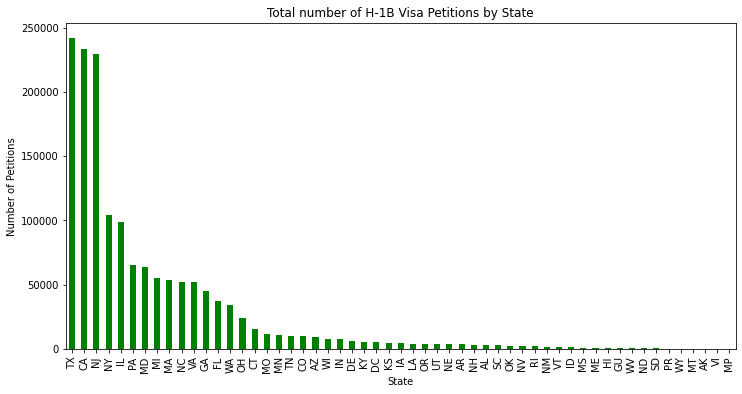

In [126]:
# Create a bar chart of the failure percentage by state
state_count.plot(kind='bar', figsize=(12, 6), color='green')

# Set the chart title and axis labels
plt.title('Total number of H-1B Visa Petitions by State')
plt.xlabel('State')
plt.ylabel('Number of Petitions')

# Display the chart
plt.show()

To be sure of our assumption, let's look at the correlation:

In [127]:
correlation = state_counts["failure"].corr(state_count)

In [128]:
correlation

-0.297449238427356

There is a weak but negative dependence, which was required to be proved

To determine which cities have the most number of petitions:

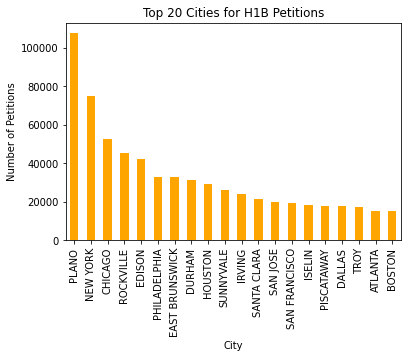

In [129]:
# Get the counts of each unique employer city
city_counts = df['EMPLOYER_CITY'].value_counts()

# Plot the top 20 cities
top_cities = city_counts[:20]
top_cities.plot(kind='bar', title='Top 20 Cities for H1B Petitions', color='orange')
plt.xlabel('City')
plt.ylabel('Number of Petitions')
plt.show()

For interest, we looked at the statistics by city. It can be seen in the forefront of the main cities of the leading states in terms of the number of petitions.

Summarizing the results obtained, we came to the conclusion that in large and developed states, the number of refusals is lower, and this is due to the fact that in such states there are many large companies that can afford to attract many times more migrants for work. We also have a graph where these states lead in the number of petitions. A correlation was also calculated, which showed a negative relationship, which means that the more petitions sent from a particular state, which means that the larger the state itself, the lower the failure rate.

##### Q8. What are the highest paid states for foreign employees?

In [130]:
# group the data by state and calculate the mean WAGE_RATE_OF_PAY for each state
df_state = df.groupby('WORKSITE_STATE')[['WAGE_RATE_OF_PAY']].mean()

# create a new column to indicate whether each state's wage rate is higher or lower than the mean
df_state['Higher Than Mean'] = df_state['WAGE_RATE_OF_PAY'] > df['WAGE_RATE_OF_PAY'].mean()

<Figure size 864x432 with 0 Axes>

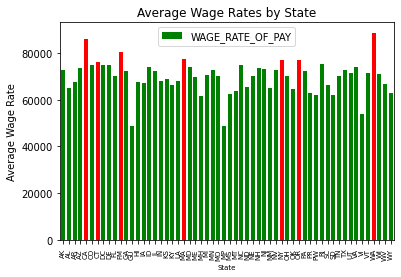

In [131]:
# create a bar chart of the two categories of states
colors = ['red' if x else 'green' for x in df_state['Higher Than Mean']]
plt.figure(figsize=(12, 6)) 
df_state.plot(kind='bar', y='WAGE_RATE_OF_PAY', color=colors, width=0.7)

# add labels and a title to the plot
plt.xlabel('State', fontsize=7)
plt.ylabel('Average Wage Rate')
plt.title('Average Wage Rates by State')

plt.xticks(fontsize=7) # rotate x-axis labels for readability and adjust font size
plt.tick_params(axis='x', which='major', pad=5)  # adjust spacing between x-axis tick labels


plt.show()

This script first calculates the mean WAGE_RATE_OF_PAY across all states and creates a new column in the df_state dataframe to indicate whether each state's wage rate is higher or lower than the mean. It then creates a bar chart of the two categories of states, with red bars indicating states with average wage rates higher than the mean by state, and green bars indicating states with average wage rates lower than the mean. 

Minimum wages in large popular states for foreign workers are higher, namely in California (CA), Massachusetts (MA), New York (NY), Washington (WA) and so on

##### Q9. Is the minimum wage for employers petitioning for foreign workers above or below the state average?

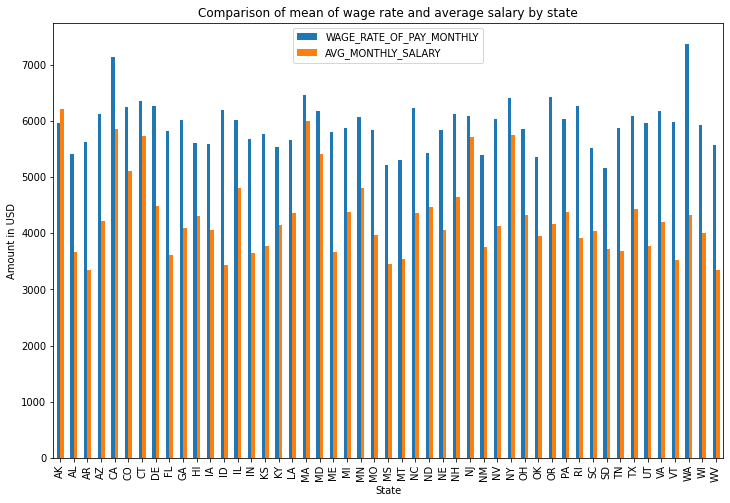

In [132]:
# Group the data by state and calculate the mean of 'WAGE_RATE_OF_PAY_MONTHLY' and 'AVG_MONTHLY_SALARY' for each state
grouped_data = df_new_data.groupby(['WORKSITE_STATE'])[['WAGE_RATE_OF_PAY_MONTHLY', 'AVG_MONTHLY_SALARY']].mean()

# Plot the results on a bar chart
grouped_data.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of mean of wage rate and average salary by state')
plt.xlabel('State')
plt.ylabel('Amount in USD')
plt.show()

In all states except one (Alabama (AL)) the employer's offered wage is higher than the state average, it is likely that this trend is due to the fact that more qualified workers receive a work visa

##### Q10. What is the ratio of the number of petitions to the number of employed population to the share of unemployment?

In [133]:
# Filter the dataframe to include only successful petitions
successful_petitions = df_new_data[df_new_data['CASE_STATUS'].isin(['CERTIFIED'])]

# Group the data by YEAR and STATE and count the number of successful petitions in each group
successful_petitions_by_year_state = successful_petitions.groupby(['YEAR', 'WORKSITE_STATE']).size().reset_index(name='COUNT_SUCCESS')

# Merge the successful petitions data with the UNEMPLOYMENT_RATE data by STATE and YEAR
merged_data = pd.merge(successful_petitions_by_year_state, df_new_data[['YEAR', 'WORKSITE_STATE', 'UNEMPLOYMENT_RATE', 'NUMBER_OF_EMPLOYERS_MLN']].drop_duplicates(), on=['YEAR', 'WORKSITE_STATE'], how='left')

# Calculate the percentage of successful petitions for each combination of state and year
merged_data['MIGRANTS_IN_WORKFORCE'] = ((merged_data['COUNT_SUCCESS']/1000000) / merged_data['NUMBER_OF_EMPLOYERS_MLN']) * 100

# Group the data by STATE and YEAR and calculate the mean unemployment rate and mean percent of successful petitions in each group
result = merged_data.groupby(['WORKSITE_STATE', 'YEAR']).agg({'UNEMPLOYMENT_RATE': 'mean', 'MIGRANTS_IN_WORKFORCE': 'mean'}).reset_index()

# Print the result
print(result)


    WORKSITE_STATE  YEAR  UNEMPLOYMENT_RATE  MIGRANTS_IN_WORKFORCE
0               AK  2014                6.9               0.042000
1               AK  2015                6.5               0.029667
2               AK  2016                6.9               0.027667
3               AL  2014                6.8               0.063947
4               AL  2015                6.1               0.064850
..             ...   ...                ...                    ...
141             WI  2015                4.6               0.202588
142             WI  2016                4.1               0.159993
143             WV  2014                6.6               0.028831
144             WV  2015                6.8               0.041278
145             WV  2016                5.9               0.038988

[146 rows x 4 columns]


In [134]:
df_new_2016=result[result['YEAR']==2016]
df_new_2015=result[result['YEAR']==2015]
df_new_2014=result[result['YEAR']==2014]

<Figure size 720x432 with 0 Axes>

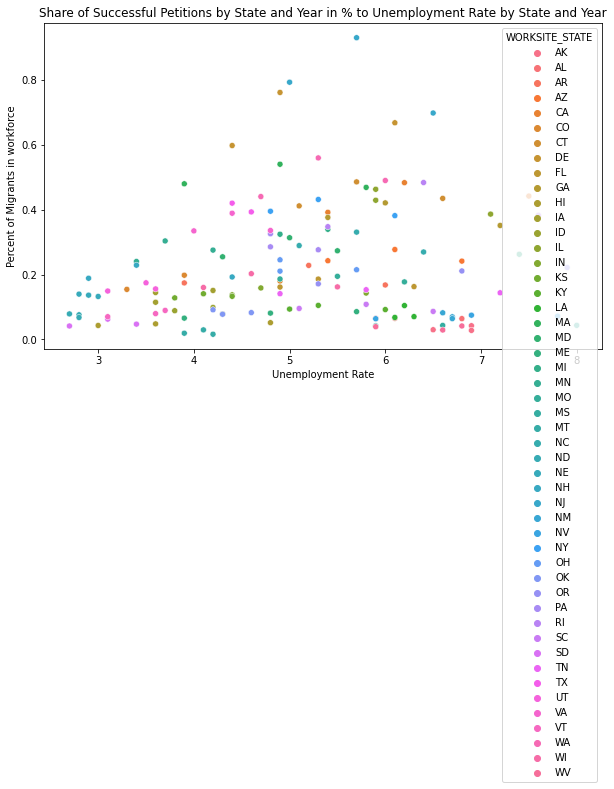

In [135]:
# Plot the scatter plot
plt.figure(figsize=(10,6))
plt.figure(figsize=(10,6))
sns.scatterplot(data=result, x='UNEMPLOYMENT_RATE', y='MIGRANTS_IN_WORKFORCE', hue='WORKSITE_STATE')
plt.title('Share of Successful Petitions by State and Year in % to Unemployment Rate by State and Year')
plt.xlabel('Unemployment Rate')
plt.ylabel('Percent of Migrants in workforce')
plt.show()

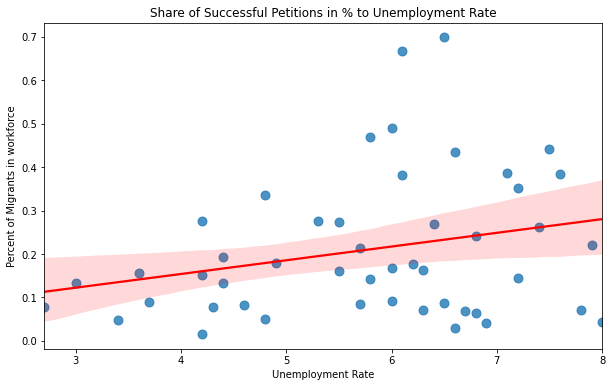

In [136]:
scatter_plot(df_new_2014)

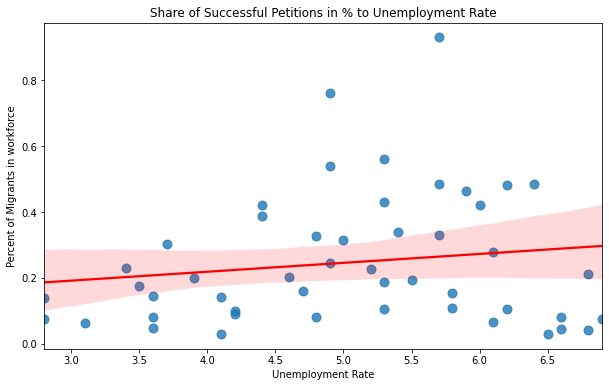

In [137]:
scatter_plot(df_new_2015)

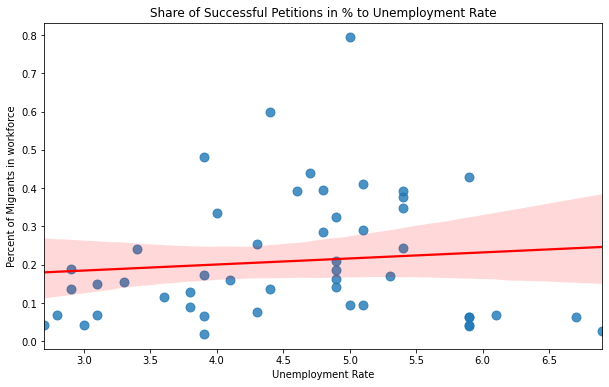

In [138]:
scatter_plot(df_new_2016)

From the graph, we can see an upward trend, which means that the higher the proportion of migrants in the labor force, the higher the unemployment. This may be due to the fact that highly skilled migrants begin to take jobs of the local population, which increases the unemployment rate.

## Summary

### Actions

An analysis of data on US visa type H-1B was carried out. The data were taken for 3 years (2014-2016). The process also added data on the percentage of unemployment, the average salary by state and the number of employed people at the end of each year.

Research, collection, understanding, cleaning, preparation, visualization and also direct analysis of data was carried out. During the analysis, python libraries were used, both for preprocessing and analysis, and for visualization. I also created my own methods for optimizing the code.

All column names have been brought to a unified form, data formats have been corrected for correct ones, outlayers have been excluded, missing values have been filled in, unnecessary columns and duplicates have been removed, statistical tests have been applied, new features have been generated, the index column has been put in order, data was aggregated and filtered where necessary, various types of graphs for visualizations were used, as well as columns with continuous data ('WAGE_RATE_OF_PAY' and 'PREVAILING_WAGE') were brought to a single form in monthly equivalent.

In the end, an analysis was carried out, both of individual components and a multi-analysis, where some interesting facts, patterns and insights were found.

### Facts

- At the beginning of the year, employers are more active in hiring foreign employees.
- 2015 is the leader in the number of petitions.
- In 2014, the lowest rates on the minimum threshold in wages from employers.
- The employer's minimum wage is strongly and positively correlated with the prevailing wage.
- The salary of employers falls when the demand for work increases.
- Petitions are generally considered no longer than a week, but there are exceptions.
- In most cases, employers conclude 3-year contracts.
- In 88% of cases petitions were successfully approved during the analyzed three years.
- Texas, California, New York - the leader in the number of petitions sent.
- The most popular payment frequency is first of all annual and then hourly.
- H-1B visas are requested for full-time work.
- 0,1% of employers who has been previously found to be a Willful Violator

### Insights

1. In 2011-2012, Microsoft was the leader in the number of petitions filed. In 2013-2016, a company, named INFOSYS LIMITED.
2. The minimum rate of employers does not depend on the success of petitions, however, in cases where this rate is lower than the prevailing wage, the probability of refusal is high, namely 82.57%.
3. Computer science, programming, everything related to IT - that's what is most in demand among employers in the US and foreign job seekers.
4. Professions from public services are 100% approved.
5. The Willful Violator score does not greatly affect the decision on the petition.
6. The highest failure rate is 20% in the northen mariana islands and the lowest in Maryland.
7. In large states, the rejection rate is low, which is associated with the number of petitions sent from these states. The more staff - the more companies are there - the more places for workers - the more people are looking for - the more petitions are sent - the smaller the rejection rate for them.
8. California, Massachusetts, New York, Washington, Oregon, Connecticut have the highest wage minimums.
9. The minimum monthly salary from an employer hiring foreign workers with an H-1B visa in all states except one (Alabama) is higher than the state average.
10. The higher the proportion of migrants in the labor force, the higher the unemployment.